In [2]:
import allel
import numpy as np
import pandas as pd

In [179]:
callset = allel.read_vcf('modern_imputed.vcf.gz', fields=['variants/CHROM', 'variants/POS'])

In [184]:
# Extract chromosome and position arrays
chroms = callset['variants/CHROM']
positions = callset['variants/POS']

# Create a DataFrame for convenience
df = pd.DataFrame({'chrom': chroms, 'pos': positions})

# Calculate SNP spacing per chromosome
spacing_results = []

for chrom, group in df.groupby('chrom'):
    pos = group['pos'].values
    gaps = np.diff(pos)
    avg_gap = gaps.mean() if len(gaps) > 0 else np.nan
    spacing_results.append({
        'chrom': chrom,
        'num_snps': len(pos),
        'avg_spacing_bp': avg_gap
    })

# Convert to DataFrame
spacing_df = pd.DataFrame(spacing_results)

# Optional: print genome-wide average
genome_avg = spacing_df['avg_spacing_bp'].mean()
print(f"Genome-wide average SNP spacing: {genome_avg:.2f} bp")

Genome-wide average SNP spacing: 82.25 bp


In [187]:
spacing_df

chrom  num_snps  avg_spacing_bp
0     1    379496       80.153667
1     2    233395       84.092235
2     3    270587       86.697320
3     4    234143       79.367717
4     5    330915       80.959781

In [188]:
chrom_gaps

array([  5,  27,  14, ...,  61, 180,  62], dtype=int32)

In [189]:


# Get genome-wide gaps
df_sorted = df.sort_values(['chrom', 'pos'])
gaps = []

for chrom, group in df_sorted.groupby('chrom'):
    pos = group['pos'].values
    chrom_gaps = np.diff(pos)
    gaps.extend(chrom_gaps)

gaps = np.array(gaps)

In [192]:
len(gaps)

1448531

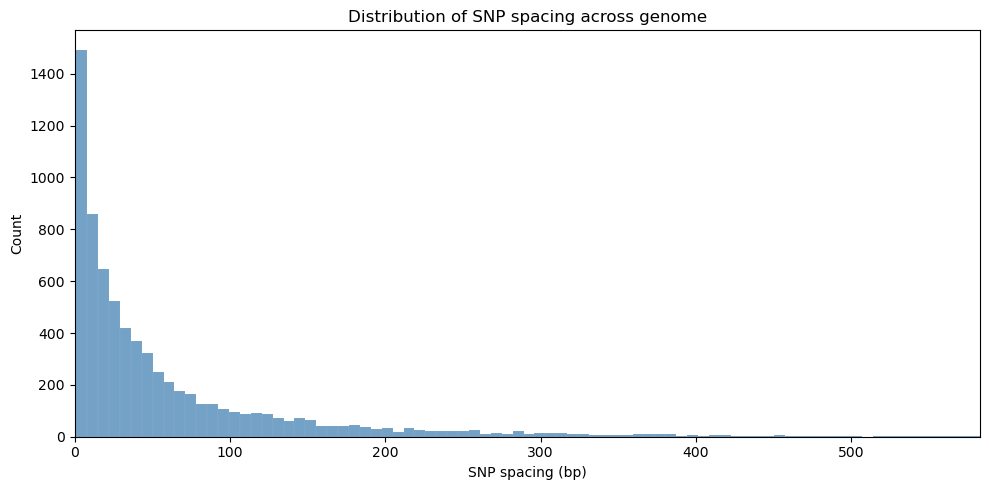

In [205]:
# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(pd.Series(gaps).sample(frac=0.005).reset_index()[0], kde=False, color='steelblue', edgecolor='white')
plt.xlabel('SNP spacing (bp)')
plt.ylabel('Count')
plt.title('Distribution of SNP spacing across genome')
plt.xlim(0, np.percentile(gaps, 99))  # Limit to 99th percentile for clarity
plt.tight_layout()
plt.show()

In [ ]:
### for usign selscan we need to make sure:

- the vcf file is phased
- there is no signle missing genotype

bcftools view -g ^miss -m2 -M2 -v snps \
  modern_shared_paired_samples_filtered_biallelic.vcf.gz \
  -Oz -o modern_shared_paired_samples_filtered_biallelic_selscan.vcf.gz


- laso selscan uses the ID column as unique identifier of each snps so we need to populate that 


bcftools annotate \
  --set-id '%CHROM\_%POS' \
  modern_shared_paired_samples_filtered_biallelic_selscan.vcf.gz \
  -Oz -o modern_selscan_with_ids.vcf.gz

- selscan runs poer chroomosmes so we will need to slip the vcf file into chroomosoems

for CHR in {1..5}; do
  echo "Extracting chromosome $CHR..."
  bcftools view -r $CHR modern_selscan_with_ids.vcf.gz -Oz -o modern_chr${CHR}.vcf.gz
  bcftools index modern_chr${CHR}.vcf.gz
done

# one run 
selscan --nsl \
    --vcf chr1_wmiss.vcf.gz \
    --out selscan_chr1_wmiss_nsl \
    --threads 2



- now run selscan  per chrososmes 

for CHR in {1..5}; do
  echo "Running selscan on chromosome $CHR..."

  selscan --nsl \
    --vcf modern_chr${CHR}.vcf.gz \
    --out selscan_chr${CHR}_nsl \
    --threads 2

  echo "Normalizing chromosome $CHR..."

  norm --nsl \
    --bins 100 \
    --files selscan_chr${CHR}_nsl.nsl.out
done





I run into the isue that selscan cannot accept missing genotypes and in the 10001 genome vcf file 98% of the variant have at least one missing genotypes, 
so that would filter out too many sites

so im goiung to use beagle to iunpute missing sites, base don already filtering for sites with more than 10%missing

In [1]:
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import glob
import re

In [44]:

# Find all normalized nSL files
nsl_files = sorted(glob.glob("selscan_chr*_nsl.nsl.out.100bins.norm"))

dfs = []
for file in nsl_files:
    # Extract chromosome number using regex
    chr_num = int(re.search(r"chr(\d+)", file).group(1))
    
    # Load file with appropriate column names
    df = pd.read_csv(file , delim_whitespace=True, header=None,
                 names=["snp_id", "pos", "freq", "sl1", "sl0", "raw_nsl", "norm_nsl", "flag"])
    df["chrom"] = f"{chr_num}"
    df["chrom_numeric"] = chr_num
    dfs.append(df)

# Concatenate all chromosomes into one DataFrame
nsl_all = pd.concat(dfs, ignore_index=True)


/tmp/ipykernel_43404/2589772949.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file , delim_whitespace=True, header=None,
/tmp/ipykernel_43404/2589772949.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file , delim_whitespace=True, header=None,
/tmp/ipykernel_43404/2589772949.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file , delim_whitespace=True, header=None,
/tmp/ipykernel_43404/2589772949.py:14: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file , delim_whitespace=True, header=None,
/tmp/ipykernel_43404/2589772

We will need to inpute the vcf file since there are too many missing genotypes

In [46]:



import subprocess

# Define paths and filenames
vcf_file = "modern_shared_paired_samples_filtered_biallelic.vcf.gz"
output_prefix = "modern_imputed"
beagle_jar_path = "/home/tbellagio/scratch/selection_scan/selection_scan/beagle.jar"  # Replace with actual path
sbatch_path = "/home/tbellagio/scratch/selection_scan/selection_scan"  # Replace with actual path
job_index = 1  # or loop variable if submitting multiple jobs

# Construct SLURM script content
sbatch_command = f"""#!/bin/bash
#SBATCH --job-name="beagle_{job_index}"
#SBATCH --time=48:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=4
#SBATCH --mem=16G
#SBATCH --output={sbatch_path}/beagle_{job_index}_output.txt
#SBATCH --mail-user=tbellagio@carnegiescience.edu
#SBATCH --mail-type=FAIL

java -Xmx16g -jar {beagle_jar_path} \\
  gt={vcf_file} \\
  out={output_prefix} \\
  impute=true \\
  nthreads=2
"""

# Write the SLURM script to file
sbatch_file = f"sbatch_beagle_{job_index}.sh"
with open(sbatch_file, 'w') as file:
    file.write(sbatch_command)

# Submit the job
subprocess.run(['sbatch', sbatch_file])


Submitted batch job 68179


CompletedProcess(args=['sbatch', 'sbatch_beagle_1.sh'], returncode=0)

In [ ]:
modern_imputed.vcf.gz

In [ ]:
## this didnt retunr anything, menaing htat the vcf file has bee nfully inputed 
bcftools query -f '[%GT]\n' modern_imputed.vcf.gz | \
awk '{for (i=1; i<=NF; i++) if ($i ~ /\./) {count++; break}} END {print count}'


In [ ]:
## so now again, separate the chromosmes and run selscan 

In [ ]:
for CHR in {1..5}; do
  echo "Extracting chromosome $CHR..."
  bcftools view -r $CHR modern_imputed.vcf.gz -Oz -o modern_chr${CHR}.vcf.gz
  bcftools index modern_chr${CHR}.vcf.gz
done

# one run 
selscan --nsl \
    --vcf chr1_wmiss.vcf.gz \
    --out selscan_chr1_wmiss_nsl \
    --threads 2



- now run selscan  per chrososmes 

for CHR in {1..5}; do
  echo "Running selscan on chromosome $CHR..."

  selscan --nsl \
    --vcf modern_chr${CHR}.vcf.gz \
    --out selscan_chr${CHR}_nsl \
    --threads 2

  echo "Normalizing chromosome $CHR..."

  norm --nsl \
    --bins 100 \
    --files selscan_chr${CHR}_nsl.nsl.out
done

In [4]:
pwd

'/carnegie/nobackup/scratch/tbellagio/selection_scan/selection_scan'

In [206]:
import subprocess
import datetime

# Path where SLURM logs and scripts go
sbatch_path = "/carnegie/nobackup/scratch/tbellagio/selection_scan/selection_scan"
batch_script_list = []

# Optional: Add timestamp to avoid collisions when re-running
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

for chr_num in range(1, 6):
    sbatch_filename = f"sbatch_selscan_chr{chr_num}_{timestamp}.sh"
    log_filename = f"{sbatch_path}/selscan_chr{chr_num}_{timestamp}_output.txt"

    sbatch_command = f"""#!/bin/bash
#SBATCH --job-name="selscan_chr{chr_num}"
#SBATCH --time=4:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=4
#SBATCH --mem=8G
#SBATCH --output={log_filename}
#SBATCH --mail-user=tbellagio@carnegiescience.edu
#SBATCH --mail-type=FAIL

cd /carnegie/nobackup/scratch/tbellagio/selection_scan/selection_scan
pwd
source /home/tbellagio/miniforge3/etc/profile.d/conda.sh
conda activate /home/tbellagio/miniforge3/envs/gwas

echo "Running selscan on chromosome {chr_num}..."

selscan --nsl \\
  --vcf modern_chr{chr_num}.vcf.gz \\
  --out selscan_chr_maf01_{chr_num}_nsl \\
  --maf 0.01 \\
  --threads 4

echo "Normalizing chromosome {chr_num}..."

norm --nsl \\
  --bins 100 \\
  --files selscan_chr{chr_num}_nsl.nsl.out
"""

    # Save batch script
    with open(sbatch_filename, 'w') as f:
        f.write(sbatch_command)

    # Track it
    batch_script_list.append(sbatch_filename)



In [12]:
batch_script_list[1]

'sbatch_selscan_chr2_20250714_121357.sh'

In [18]:
# Submit job
subprocess.run(['sbatch', batch_script_list[0]])

Submitted batch job 68283


CompletedProcess(args=['sbatch', 'sbatch_selscan_chr1_20250714_121634.sh'], returncode=0)

In [207]:
for i in range(len(batch_script_list)):
    subprocess.run(['sbatch', batch_script_list[i]])

Submitted batch job 68368
Submitted batch job 68369
Submitted batch job 68370
Submitted batch job 68371
Submitted batch job 68372


In [ ]:
## nsl 

In [3]:
## normlaize 
norm --nsl \
  --bins 100 \
  --files selscan_chr_maf01_*_nsl.nsl.out

[]

In [6]:
nsl_files

['selscan_chr_maf01_1_nsl.nsl.out.100bins.norm',
 'selscan_chr_maf01_2_nsl.nsl.out.100bins.norm',
 'selscan_chr_maf01_3_nsl.nsl.out.100bins.norm',
 'selscan_chr_maf01_4_nsl.nsl.out.100bins.norm',
 'selscan_chr_maf01_5_nsl.nsl.out.100bins.norm']

In [7]:
import pandas as pd
import glob
import re

# Find all normalized nSL files
# nsl_files = sorted(glob.glob("selscan_chr*_nsl.nsl.out.100bins.norm"))
nsl_files = sorted(glob.glob("selscan_chr_maf01_*_nsl.nsl.out.100bins.norm"))
#selscan_chr_maf01_*_nsl.nsl.out.100bins
dfs = []
for file in nsl_files:
    chr_num = file.split('_')[3]
    # Extract chromosome number using regex
    #chr_num = int(re.search(r"chr(\d+)", file).group(1))
    
    # Load file with appropriate column names
    df = pd.read_csv(file , delim_whitespace=True, header=None,
                 names=["snp_id", "pos", "freq", "sl1", "sl0", "raw_nsl", "norm_nsl", "flag"])
    df["chrom"] = f"{chr_num}"
    df["chrom_numeric"] = chr_num
    dfs.append(df)

# Concatenate all chromosomes into one DataFrame
nsl_all = pd.concat(dfs, ignore_index=True)

In [8]:
nsl_all

snp_id       pos      freq       sl1       sl0   raw_nsl  norm_nsl  \
0            .     12584  0.555556   36.5294  104.4960 -1.051030 -1.701990   
1            .     12947  0.206349  137.5040   43.3547  1.154240  1.092130   
2            .     13260  0.412698   49.3143   72.0236 -0.378780 -0.936910   
3            .     13538  0.423280   47.2742   74.7794 -0.458578 -1.033800   
4            .     13797  0.010582  183.6670   37.3449  1.592930  0.681304   
...        ...       ...       ...       ...       ...       ...       ...   
1082268      .  26780507  0.037037   54.0440   48.5634  0.106927 -1.846010   
1082269      .  26780582  0.026455  193.4220   47.7861  1.398140  0.448647   
1082270      .  26780677  0.031746  141.8180   48.8172  1.066460 -0.017875   
1082271      .  26780689  0.677249   42.0608  195.9410 -1.538700 -2.099340   
1082272      .  26780876  0.031746  142.3030   44.1494  1.170380  0.180117   

         flag chrom chrom_numeric  
0           0     1             1  
1           0     1             1  
2           0     1             1  
3           0     1             1  
4           0     1             1  
...       ...   ...           ...  
1082268     0     5             5  
1082269     0     5             5  
1082270     0     5             5  
1082271     1     5             5  
1082272     0     5             5  

[1082273 rows x 10 columns]

In [23]:
#df = pd.read_csv(file, delim_whitespace=True, header=None,
#                 names=["snp_id", "pos", "freq", "sl1", "sl0", "raw_nsl", "norm_nsl", "flag"])

/tmp/ipykernel_43404/4292192406.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(file, delim_whitespace=True, header=None,


In [18]:
#df = pd.read_csv('selscan_chr5_nsl.nsl.out.100bins.norm', delim_whitespace=True, header=None)

/tmp/ipykernel_43404/1843978951.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('selscan_chr5_nsl.nsl.out.100bins.norm', delim_whitespace=True, header=None)


In [9]:
# Sort by chromosome and position
nsl_all = nsl_all.sort_values(["chrom_numeric", "pos"])

# Compute cumulative basepair position for plotting
chrom_offsets = nsl_all.groupby("chrom_numeric")["pos"].max().cumsum().shift(fill_value=0)
nsl_all["pos_cum"] = nsl_all.apply(lambda  row: row["pos"] + chrom_offsets[row["chrom_numeric"]], axis=1)

In [10]:
df = nsl_all.copy()

In [19]:
nsl_all.to_csv('nsl_sll_maf01.csv',index=None)

In [11]:
df.dtypes

snp_id            object
pos                int64
freq             float64
sl1              float64
sl0              float64
raw_nsl          float64
norm_nsl         float64
flag               int64
chrom             object
chrom_numeric     object
pos_cum            int64
dtype: object

In [14]:
import matplotlib.pyplot as plt

In [12]:
gene_df = pd.read_csv('../genes_df.csv')

/tmp/ipykernel_2696783/3099983615.py:18: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/tbellagio/miniforge3/envs/pipeline_snakemake/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


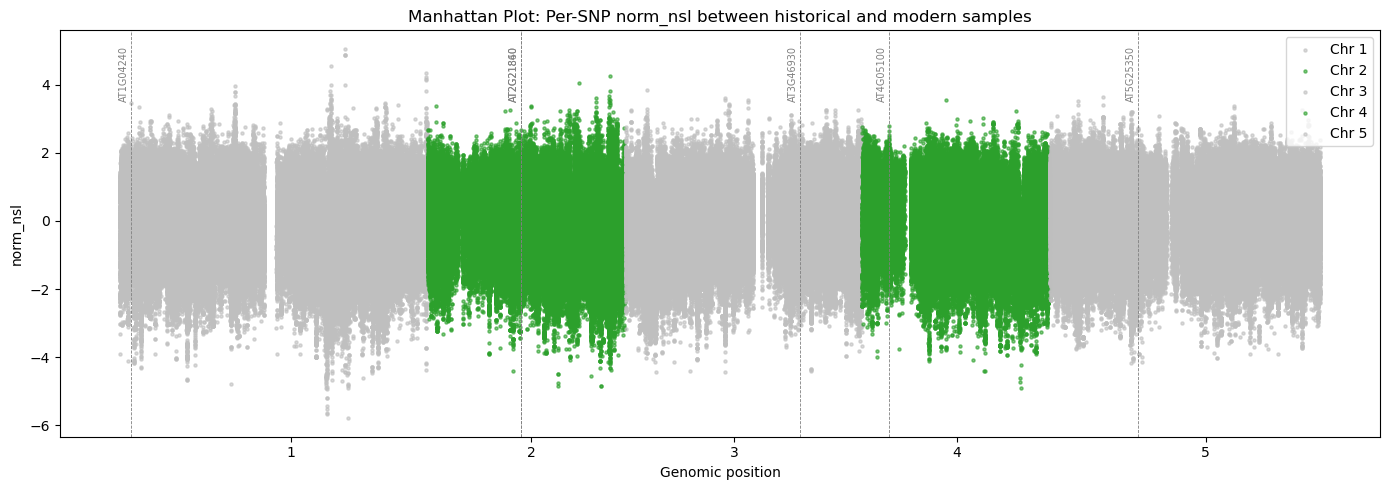

In [15]:
plt.figure(figsize=(14, 5))
colors = ['#bfbfbf', '#2ca02c']

for i, (chrom, group) in enumerate(df.groupby('chrom_numeric')):
    plt.scatter(group['pos_cum'], group['norm_nsl'], s=5, alpha=0.6, color=colors[i % 2], label=f'Chr {group.chrom.iloc[0]}')
plt.legend().remove() 


# Chromosome ticks
xticks = df.groupby('chrom_numeric')['pos_cum'].median()
xtick_labels = df.groupby('chrom_numeric')['chrom'].first()

plt.xticks(ticks=xticks, labels=xtick_labels)
plt.xlabel('Genomic position')
plt.ylabel('norm_nsl')
plt.title('Manhattan Plot: Per-SNP norm_nsl between historical and modern samples')
plt.legend()
plt.tight_layout()

# Draw grey vertical lines and add gene ID labels
for _, row in gene_df.iterrows():
    chrom = str(row['chrom'])
    gene_start = row['start']
    gene_ends = row['end']
    gene_id = row['gene_id']

    filter_df = df[(df['chrom'] == chrom) & (df['pos']>=gene_start-5000) & (df['pos']<=gene_ends+5000)]
    gene_pos_cum = filter_df.sample(1)['pos_cum'].values[0]

    # Plot vertical line
    plt.axvline(gene_pos_cum, color='grey', linestyle='--', linewidth=0.6)

    # Add gene label
    plt.text(gene_pos_cum - 7e5, df['norm_nsl'].max() * 0.7, gene_id,
             rotation=90, 
             fontsize=7, color='grey', ha='center')

plt.show()

/tmp/ipykernel_1657935/3099983615.py:18: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/tbellagio/miniforge3/envs/pipeline_snakemake/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


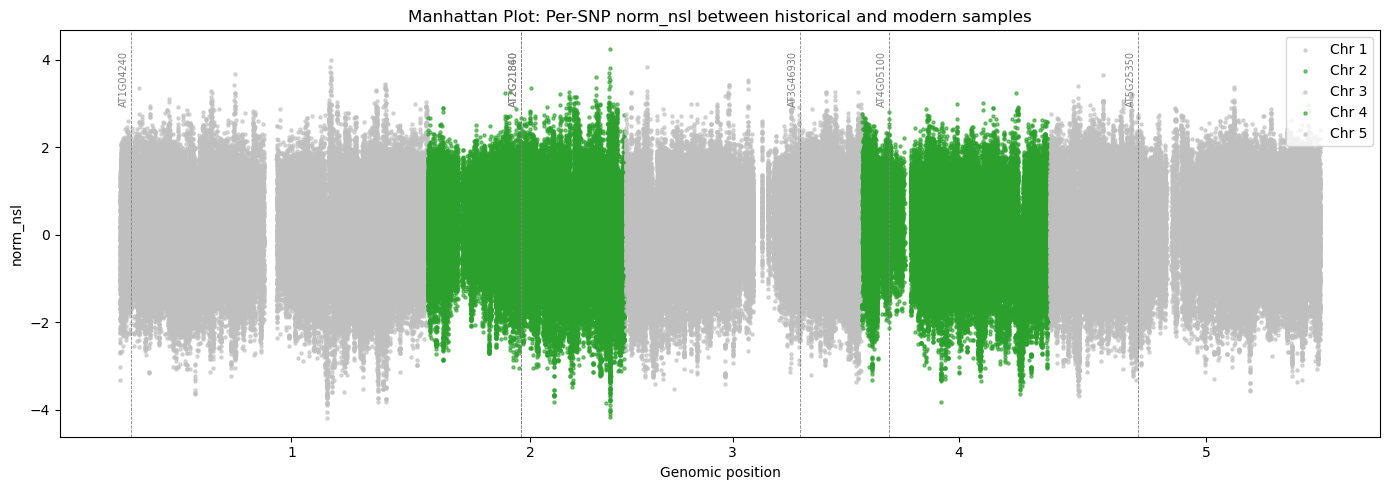

In [43]:
plt.figure(figsize=(14, 5))
colors = ['#bfbfbf', '#2ca02c']

for i, (chrom, group) in enumerate(df.groupby('chrom_numeric')):
    plt.scatter(group['pos_cum'], group['norm_nsl'], s=5, alpha=0.6, color=colors[i % 2], label=f'Chr {group.chrom.iloc[0]}')
plt.legend().remove() 


# Chromosome ticks
xticks = df.groupby('chrom_numeric')['pos_cum'].median()
xtick_labels = df.groupby('chrom_numeric')['chrom'].first()

plt.xticks(ticks=xticks, labels=xtick_labels)
plt.xlabel('Genomic position')
plt.ylabel('norm_nsl')
plt.title('Manhattan Plot: Per-SNP norm_nsl between historical and modern samples')
plt.legend()
plt.tight_layout()

# Draw grey vertical lines and add gene ID labels
for _, row in gene_df.iterrows():
    chrom = str(row['chrom'])
    gene_start = row['start']
    gene_ends = row['end']
    gene_id = row['gene_id']

    filter_df = df[(df['chrom'] == chrom) & (df['pos']>=gene_start-5000) & (df['pos']<=gene_ends+5000)]
    gene_pos_cum = filter_df.sample(1)['pos_cum'].values[0]

    # Plot vertical line
    plt.axvline(gene_pos_cum, color='grey', linestyle='--', linewidth=0.6)

    # Add gene label
    plt.text(gene_pos_cum - 7e5, df['norm_nsl'].max() * 0.7, gene_id,
             rotation=90, 
             fontsize=7, color='grey', ha='center')

plt.show()

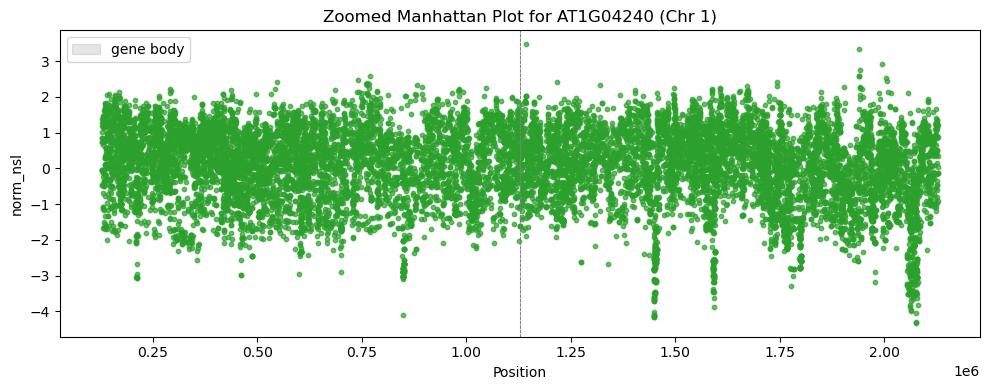

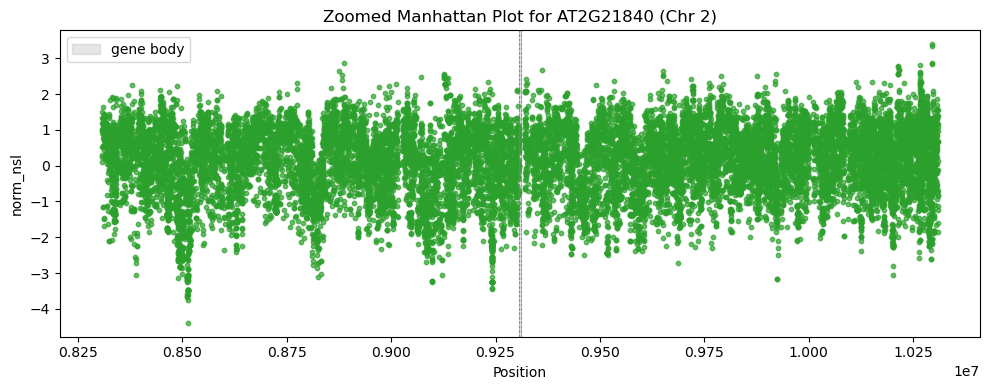

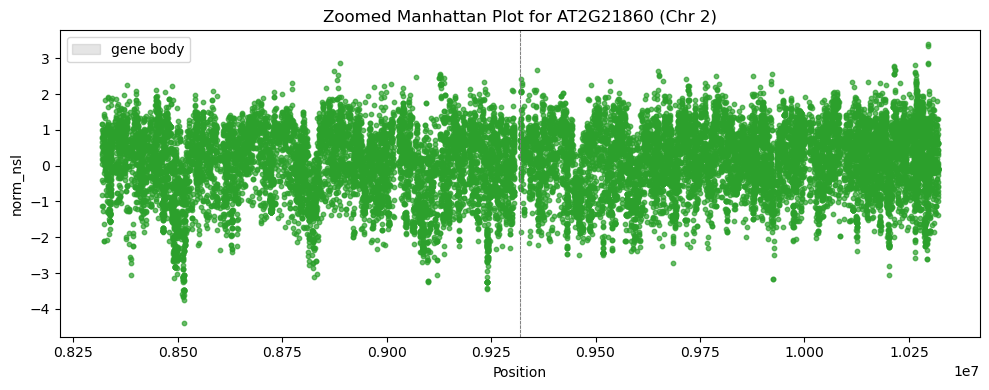

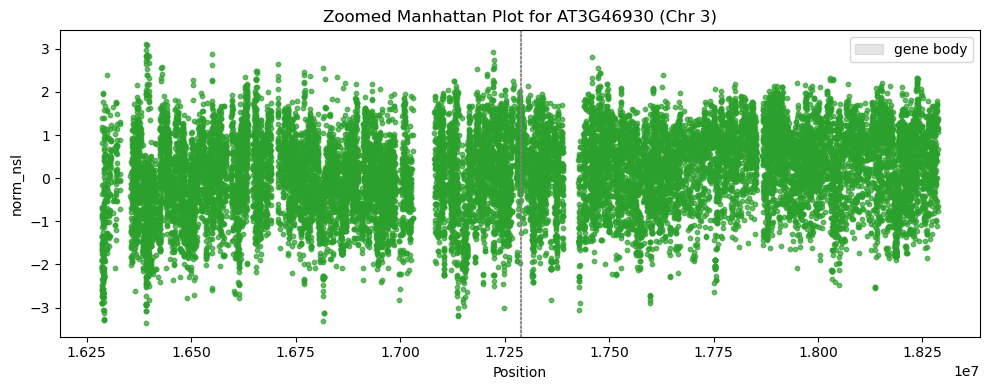

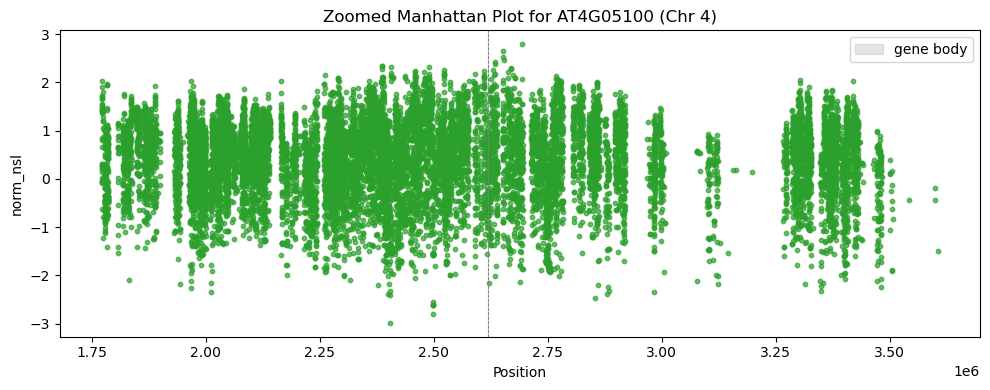

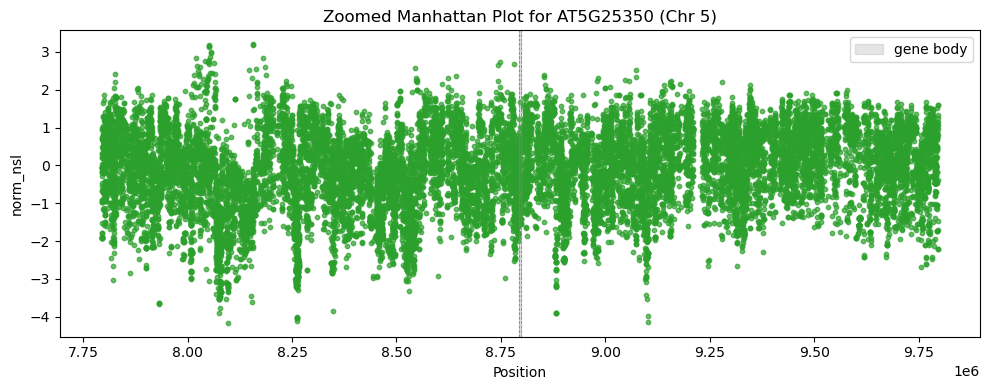

In [17]:
import matplotlib.pyplot as plt

for _, row in gene_df.iterrows():
    chrom = str(row['chrom'])
    gene_start = row['start']
    gene_end = row['end']
    gene_id = row['gene_id']
    
    # Filter region: ±5kb around gene
    region_df = df[(df['chrom'] == chrom) & (df['pos'] >= gene_start - 1000000) & (df['pos'] <= gene_end + 1000000)]

    if region_df.empty:
        continue  # Skip if no data in region

    plt.figure(figsize=(10, 4))

    # Manhattan-style scatter
    plt.scatter(region_df['pos'], region_df['norm_nsl'], s=10, alpha=0.7, color='#2ca02c')
    
    # Gene region highlight
    plt.axvspan(gene_start, gene_end, color='grey', alpha=0.2, label='gene body')
    plt.axvline(gene_start, color='grey', linestyle='--', linewidth=0.6)
    plt.axvline(gene_end, color='grey', linestyle='--', linewidth=0.6)

    # Plot labels
    plt.title(f'Zoomed Manhattan Plot for {gene_id} (Chr {chrom})')
    plt.xlabel('Position')
    plt.ylabel('norm_nsl')
    plt.legend()
    plt.tight_layout()
    plt.show()


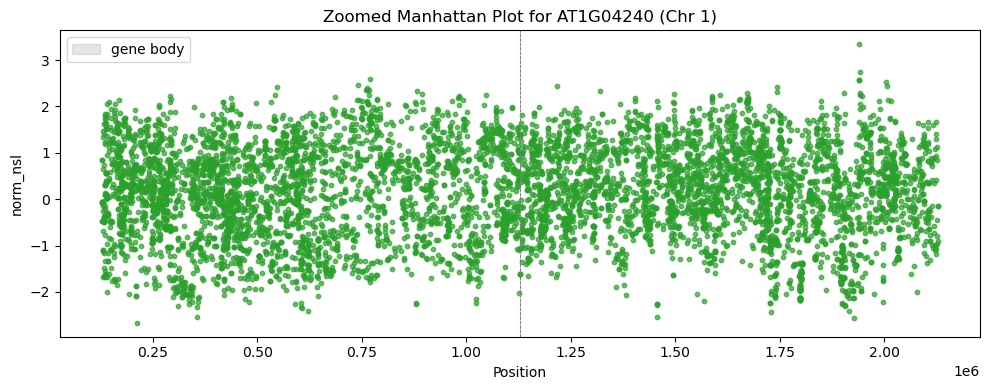

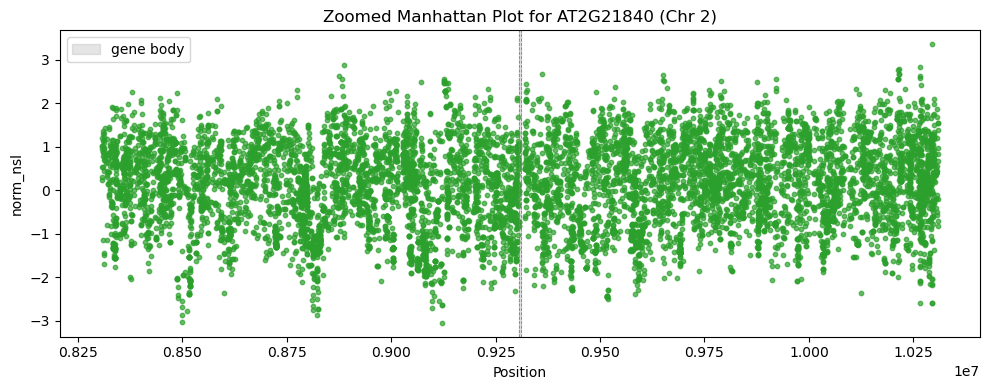

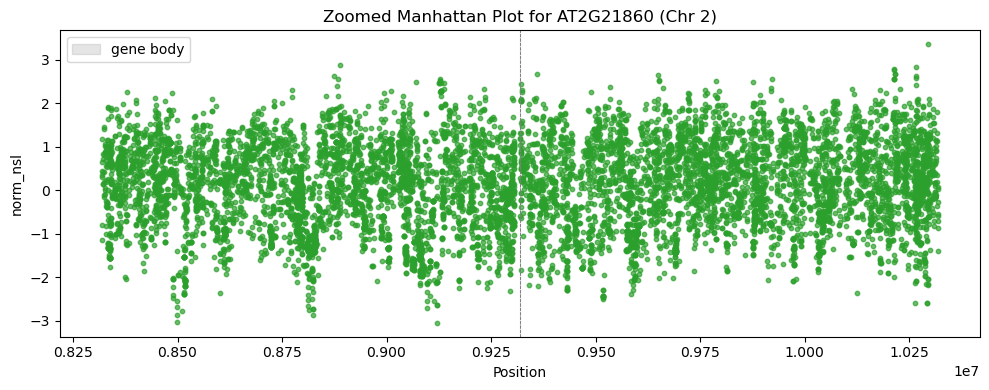

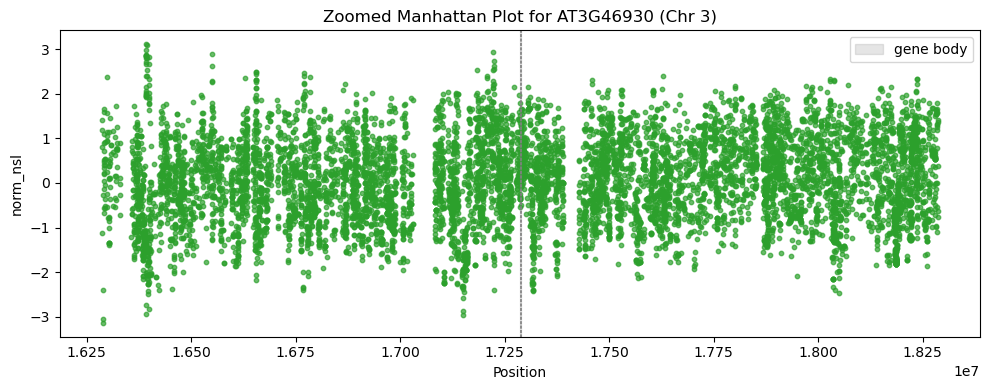

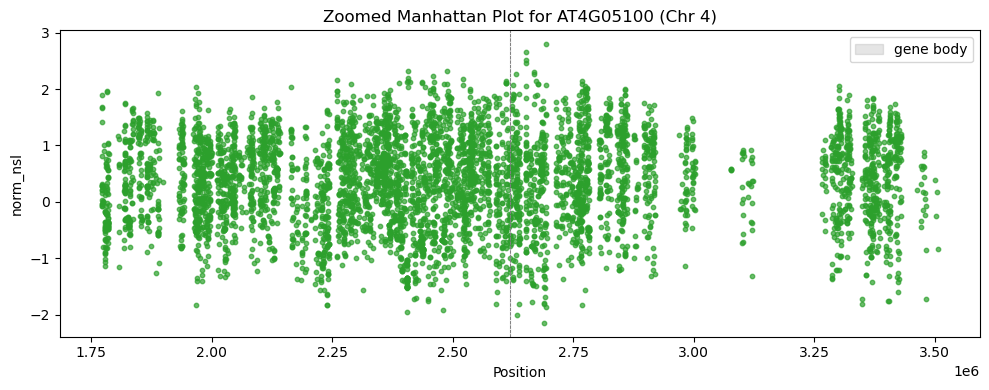

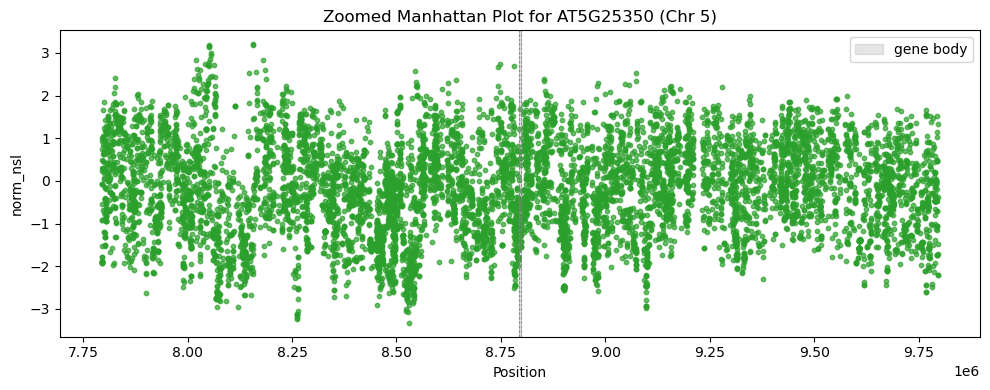

In [44]:
import matplotlib.pyplot as plt

for _, row in gene_df.iterrows():
    chrom = str(row['chrom'])
    gene_start = row['start']
    gene_end = row['end']
    gene_id = row['gene_id']
    
    # Filter region: ±5kb around gene
    region_df = df[(df['chrom'] == chrom) & (df['pos'] >= gene_start - 1000000) & (df['pos'] <= gene_end + 1000000)]

    if region_df.empty:
        continue  # Skip if no data in region

    plt.figure(figsize=(10, 4))

    # Manhattan-style scatter
    plt.scatter(region_df['pos'], region_df['norm_nsl'], s=10, alpha=0.7, color='#2ca02c')
    
    # Gene region highlight
    plt.axvspan(gene_start, gene_end, color='grey', alpha=0.2, label='gene body')
    plt.axvline(gene_start, color='grey', linestyle='--', linewidth=0.6)
    plt.axvline(gene_end, color='grey', linestyle='--', linewidth=0.6)

    # Plot labels
    plt.title(f'Zoomed Manhattan Plot for {gene_id} (Chr {chrom})')
    plt.xlabel('Position')
    plt.ylabel('norm_nsl')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
vcf

In [ ]:
snps = pd.concat([pd.Series(vcf['variants/CHROM']), pd.Series(vcf['variants/POS'])],axis=1)
snps.columns = ['chr', 'pos']

In [53]:
## generate a genetic map to run other selection scans
## there is one here https://datadryad.org/dataset/doi:10.5061/dryad.c2fqz614w

import pandas as pd
genetic_map = pd.read_csv("INRA_NAM_joint_linkage_map.csv")

In [1]:
import pandas as pd
import numpy as np

# Load the NAM genetic map
genmap = pd.read_csv("INRA_NAM_joint_linkage_map.csv")


In [2]:
# Extract bp from marker and keep chr/cM
genmap['bp'] = genmap['marker'].str.split('_').str[1].astype(int)

# Keep only necessary columns and sort
genmap = genmap[['chr', 'bp', 'cM']].sort_values(['chr', 'bp'])

In [4]:
genmap.to_csv('genetic_map.csv',index=None)

In [63]:
vcf['variants/POS']

array([     332,      346,      353, ..., 26790553, 26790733, 26790795],
      dtype=int32)

In [77]:
snps.dtypes

chr    object
pos     int32
dtype: object

In [80]:
def interpolate_map(snps_chr, map_chr):
    # Must have at least 2 points to interpolate
    if map_chr.shape[0] < 2:
        snps_chr['cM'] = np.nan
        return snps_chr
    # Interpolate genetic position using numpy
    snps_chr['cM'] = np.interp(
        snps_chr['pos'],
        map_chr['bp'],
        map_chr['cM']
    )
    return snps_chr




In [78]:
snps['chr'] = snps['chr'].astype(int)


In [81]:
# Apply by chromosome
snps_interp = (
    snps.groupby('chr')
    .apply(lambda df: interpolate_map(df.copy(), genmap[genmap['chr'] == df.name]))
    .reset_index(drop=True)
)

In [82]:
snps_interp['cM'].notna().sum()

1448536

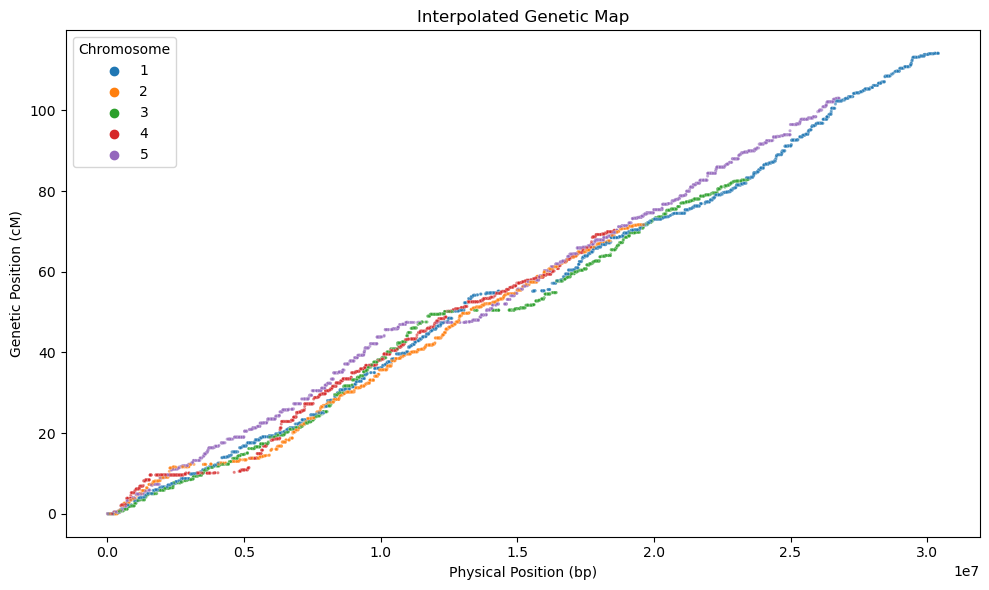

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=snps_interp.sample(10000), x='pos', y='cM', hue='chr', palette='tab10', s=5, alpha=0.6)
plt.xlabel('Physical Position (bp)')
plt.ylabel('Genetic Position (cM)')
plt.title('Interpolated Genetic Map')
plt.legend(title='Chromosome')
plt.tight_layout()
plt.show()


In [85]:
snps_interp

chr       pos            cM
0          1       332  5.000000e-08
1          1       346  5.000000e-08
2          1       353  5.000000e-08
3          1       395  5.000000e-08
4          1       471  5.000000e-08
...      ...       ...           ...
1448531    5  26790491  1.031737e+02
1448532    5  26790492  1.031737e+02
1448533    5  26790553  1.031742e+02
1448534    5  26790733  1.031758e+02
1448535    5  26790795  1.031764e+02

[1448536 rows x 3 columns]

In [87]:
snps_interp['snp_id'] = '.'

In [91]:
snps_interp = snps_interp[['chr', 'snp_id', 'cM', 'pos']]

In [92]:
#snps_interp.to_csv("selscan_ready.map", sep='\t', index=False, header=False)

In [96]:
# Save per-chromosome .map files
for chr_num in range(1, 6):
    chr_df = snps_interp[snps_interp["chr"] == chr_num]
    chr_df.to_csv(f"selscan_chr{chr_num}.map", sep='\t', index=False, header=False)


In [3]:
import subprocess
import datetime

# Path where SLURM logs and scripts go
sbatch_path = "/carnegie/nobackup/scratch/tbellagio/selection_scan/selection_scan"
batch_script_list = []

# Timestamp to keep files unique
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

for chr_num in range(1, 6):
    sbatch_filename = f"{sbatch_path}/sbatch_selscan_chr{chr_num}_{timestamp}_ihs.sh"
    log_filename = f"{sbatch_path}/selscan_chr{chr_num}_{timestamp}_ihs_output.txt"

    sbatch_command = f"""#!/bin/bash
#SBATCH --job-name="selscan_chr{chr_num}"
#SBATCH --time=24:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=4
#SBATCH --mem=8G
#SBATCH --output={log_filename}
#SBATCH --mail-user=tbellagio@carnegiescience.edu
#SBATCH --mail-type=FAIL

cd {sbatch_path}
pwd
source /home/tbellagio/miniforge3/etc/profile.d/conda.sh
conda activate /home/tbellagio/miniforge3/envs/gwas

echo "Running selscan iHS on chromosome {chr_num}..."

selscan --ihs \\
  --vcf modern_chr{chr_num}.vcf.gz \\
  --map selscan_chr{chr_num}.map \\
  --out selscan_chr{chr_num}_ihs \\
  --threads 4 \\
  --maf 0.05 \\
  --cutoff 0.05 \\
  --max-extend 1000000

echo "Done with chromosome {chr_num}"
"""

    # Save batch script
    with open(sbatch_filename, 'w') as f:
        f.write(sbatch_command)

    batch_script_list.append(sbatch_filename)


In [4]:
batch_script_list

['/carnegie/nobackup/scratch/tbellagio/selection_scan/selection_scan/sbatch_selscan_chr1_20250715_134752_ihs.sh',
 '/carnegie/nobackup/scratch/tbellagio/selection_scan/selection_scan/sbatch_selscan_chr2_20250715_134752_ihs.sh',
 '/carnegie/nobackup/scratch/tbellagio/selection_scan/selection_scan/sbatch_selscan_chr3_20250715_134752_ihs.sh',
 '/carnegie/nobackup/scratch/tbellagio/selection_scan/selection_scan/sbatch_selscan_chr4_20250715_134752_ihs.sh',
 '/carnegie/nobackup/scratch/tbellagio/selection_scan/selection_scan/sbatch_selscan_chr5_20250715_134752_ihs.sh']

In [5]:
for i in range(len(batch_script_list)):
        subprocess.run(['sbatch', batch_script_list[i]])

Submitted batch job 68356
Submitted batch job 68357
Submitted batch job 68358
Submitted batch job 68359
Submitted batch job 68360


In [208]:
import datetime

# Base path
base_path = "/carnegie/nobackup/scratch/tbellagio/selection_scan/selection_scan"
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

batch_script_list = []

# === iHH12 ===
for chr_num in range(1, 6):
    stat = "ihh12"
    script_name = f"{base_path}/sbatch_selscan_chr{chr_num}_{stat}_{timestamp}.sh"
    log_name = f"{base_path}/selscan_chr{chr_num}_{stat}_{timestamp}_output.txt"

    script = f"""#!/bin/bash
#SBATCH --job-name="selscan_chr{chr_num}_{stat}"
#SBATCH --time=4:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=4
#SBATCH --mem=8G
#SBATCH --output={log_name}
#SBATCH --mail-user=tbellagio@carnegiescience.edu
#SBATCH --mail-type=FAIL

cd {base_path}
source /home/tbellagio/miniforge3/etc/profile.d/conda.sh
conda activate /home/tbellagio/miniforge3/envs/gwas

echo "Running selscan {stat} on chromosome {chr_num}..."

selscan --ihh12 \\
  --vcf modern_chr{chr_num}.vcf.gz \\
  --map selscan_chr{chr_num}.map \\
  --out selscan_maf01_chr{chr_num}_{stat} \\
  --maf 0.01 \\
  --threads 4

echo "Done with chromosome {chr_num} - {stat}"
"""

    with open(script_name, 'w') as f:
        f.write(script)
    batch_script_list.append(script_name)

# === π (pi) ===
for chr_num in range(1, 6):
    stat = "pi"
    script_name = f"{base_path}/sbatch_selscan_chr{chr_num}_{stat}_{timestamp}.sh"
    log_name = f"{base_path}/selscan_chr{chr_num}_{stat}_{timestamp}_output.txt"

    script = f"""#!/bin/bash
#SBATCH --job-name="selscan_chr{chr_num}_{stat}"
#SBATCH --time=4:00:00
#SBATCH --nodes=1
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=4
#SBATCH --mem=8G
#SBATCH --output={log_name}
#SBATCH --mail-user=tbellagio@carnegiescience.edu
#SBATCH --mail-type=FAIL

cd {base_path}
source /home/tbellagio/miniforge3/etc/profile.d/conda.sh
conda activate /home/tbellagio/miniforge3/envs/gwas

echo "Running selscan {stat} on chromosome {chr_num}..."

selscan --pi \\
  --vcf modern_chr{chr_num}.vcf.gz \\
  --map selscan_chr{chr_num}.map \\
  --pi-win 100 \\
  --maf 0.01 \\
  --out selscan_maf01_chr{chr_num}_{stat} \\
  --threads 4

echo "Done with chromosome {chr_num} - {stat}"
"""

    with open(script_name, 'w') as f:
        f.write(script)
    batch_script_list.append(script_name)


In [209]:
batch_script_list

['/carnegie/nobackup/scratch/tbellagio/selection_scan/selection_scan/sbatch_selscan_chr1_ihh12_20250715_171521.sh',
 '/carnegie/nobackup/scratch/tbellagio/selection_scan/selection_scan/sbatch_selscan_chr2_ihh12_20250715_171521.sh',
 '/carnegie/nobackup/scratch/tbellagio/selection_scan/selection_scan/sbatch_selscan_chr3_ihh12_20250715_171521.sh',
 '/carnegie/nobackup/scratch/tbellagio/selection_scan/selection_scan/sbatch_selscan_chr4_ihh12_20250715_171521.sh',
 '/carnegie/nobackup/scratch/tbellagio/selection_scan/selection_scan/sbatch_selscan_chr5_ihh12_20250715_171521.sh',
 '/carnegie/nobackup/scratch/tbellagio/selection_scan/selection_scan/sbatch_selscan_chr1_pi_20250715_171521.sh',
 '/carnegie/nobackup/scratch/tbellagio/selection_scan/selection_scan/sbatch_selscan_chr2_pi_20250715_171521.sh',
 '/carnegie/nobackup/scratch/tbellagio/selection_scan/selection_scan/sbatch_selscan_chr3_pi_20250715_171521.sh',
 '/carnegie/nobackup/scratch/tbellagio/selection_scan/selection_scan/sbatch_selsc

In [210]:
for i in range(len(batch_script_list)):
    subprocess.run(['sbatch', batch_script_list[i]])

Submitted batch job 68373
Submitted batch job 68374
Submitted batch job 68375
Submitted batch job 68376
Submitted batch job 68377
Submitted batch job 68378
Submitted batch job 68379
Submitted batch job 68380
Submitted batch job 68381
Submitted batch job 68382


Now compiling the results i noticed that i ran the programs per chromosome, and i gave 4 hs to each stat but ihs didnt finish, while ihh12 did finish and pi of course too, so im laucnhign again ihs with 24h per chrosomomes 

In [ ]:
# ihh12

In [21]:
import glob

# Get all files in the current directory that contain 'ihh12' and end in '.out'
ihh12_out_files = glob.glob("selscan_maf01*ihh12*.out")

# Preview list
print(ihh12_out_files)

['selscan_maf01_chr4_ihh12.ihh12.out', 'selscan_maf01_chr5_ihh12.ihh12.out', 'selscan_maf01_chr3_ihh12.ihh12.out', 'selscan_maf01_chr2_ihh12.ihh12.out', 'selscan_maf01_chr1_ihh12.ihh12.out']


In [ ]:
### but first run the normalization 

# norm --ihh12 --files *.ihh12.out --bins 100
# norm --ihh12 --files selscan_maf01*.ihh12.out --bins 100


In [22]:
# Get all files in the current directory that contain 'ihh12' and end in '.out'
ihh12_out_files = glob.glob("selscan_maf01*ihh12*.out.norm")

# Preview list
print(ihh12_out_files)

['selscan_maf01_chr1_ihh12.ihh12.out.norm', 'selscan_maf01_chr3_ihh12.ihh12.out.norm', 'selscan_maf01_chr5_ihh12.ihh12.out.norm', 'selscan_maf01_chr2_ihh12.ihh12.out.norm', 'selscan_maf01_chr4_ihh12.ihh12.out.norm']


In [23]:
import pandas as pd

# Read and concatenate them
dfs = []
for f in ihh12_out_files:
    df = pd.read_csv(f, delim_whitespace=True, header=None)
    
    # Optionally add a chromosome identifier if needed
    chrom_num = f.split('_chr')[1].split('_')[0]
    df['chrom'] = int(chrom_num)
    
    dfs.append(df)

# Combine into one DataFrame
ihh12_df = pd.concat(dfs, ignore_index=True)


/tmp/ipykernel_2696783/1351825098.py:6: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, delim_whitespace=True, header=None)
/tmp/ipykernel_2696783/1351825098.py:6: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, delim_whitespace=True, header=None)
/tmp/ipykernel_2696783/1351825098.py:6: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, delim_whitespace=True, header=None)
/tmp/ipykernel_2696783/1351825098.py:6: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, delim_whitespace=True, header=None)
/tmp/ipykernel_2696783/1351825098.py:6: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f, delim_whitespace=True, header=None)


In [24]:
ihh12_df

0         1         2             3          4     5  chrom
0        .     43171  0.259259  5.241730e-09  normxpehh  crit      1
1        .     43494  0.047619  5.287350e-09  -0.314855     0      1
2        .     43795  0.105820  5.290560e-09  -0.314855     0      1
3        .     43804  0.079365  5.434660e-09  -0.314855     0      1
4        .     44228  0.079365  5.434660e-09  -0.314855     0      1
...     ..       ...       ...           ...        ...   ...    ...
1079863  .  18580614  0.026455  0.000000e+00  -0.314855     0      4
1079864  .  18580707  0.015873  0.000000e+00  -0.314855     0      4
1079865  .  18580930  0.031746  0.000000e+00  -0.314855     0      4
1079866  .  18580941  0.095238  0.000000e+00  -0.314855     0      4
1079867  .  18580966  0.026455  0.000000e+00  -0.314855     0      4

[1079868 rows x 7 columns]

In [25]:
ihh12_df.columns = ['locus', 'pos', 'freq', 'ihh12_raw', 'ihh12_norm', 'crit','chrom' ]

In [26]:
index_to_drop = ihh12_df[ihh12_df['ihh12_norm'] == 'normxpehh'].index

In [27]:
ihh12_df = ihh12_df.drop(index_to_drop).reset_index(drop=True)

In [28]:
ihh12_df['ihh12_norm'] = ihh12_df['ihh12_norm'].astype(float)

In [29]:
# Sort by chromosome and position
ihh12_df = ihh12_df.sort_values(["chrom", "pos"])

# Compute cumulative basepair position for plotting
chrom_offsets = ihh12_df.groupby("chrom")["pos"].max().cumsum().shift(fill_value=0)
ihh12_df["pos_cum"] = ihh12_df.apply(lambda  row: row["pos"] + chrom_offsets[row["chrom"]], axis=1)

In [1]:
gene_df = pd.read_csv('../genes_df.csv')

NameError: name 'pd' is not defined

In [31]:
df = ihh12_df.copy()

In [33]:
df.head()

locus    pos      freq     ihh12_raw  ihh12_norm crit  chrom  pos_cum
0     .  43494  0.047619  5.287350e-09   -0.314855    0      1    43494
1     .  43795  0.105820  5.290560e-09   -0.314855    0      1    43795
2     .  43804  0.079365  5.434660e-09   -0.314855    0      1    43804
3     .  44228  0.079365  5.434660e-09   -0.314855    0      1    44228
4     .  44389  0.063492  5.434660e-09   -0.314855    0      1    44389

In [65]:
#df = df.sample(frac = .7)

ValueError: a must be greater than 0 unless no samples are taken

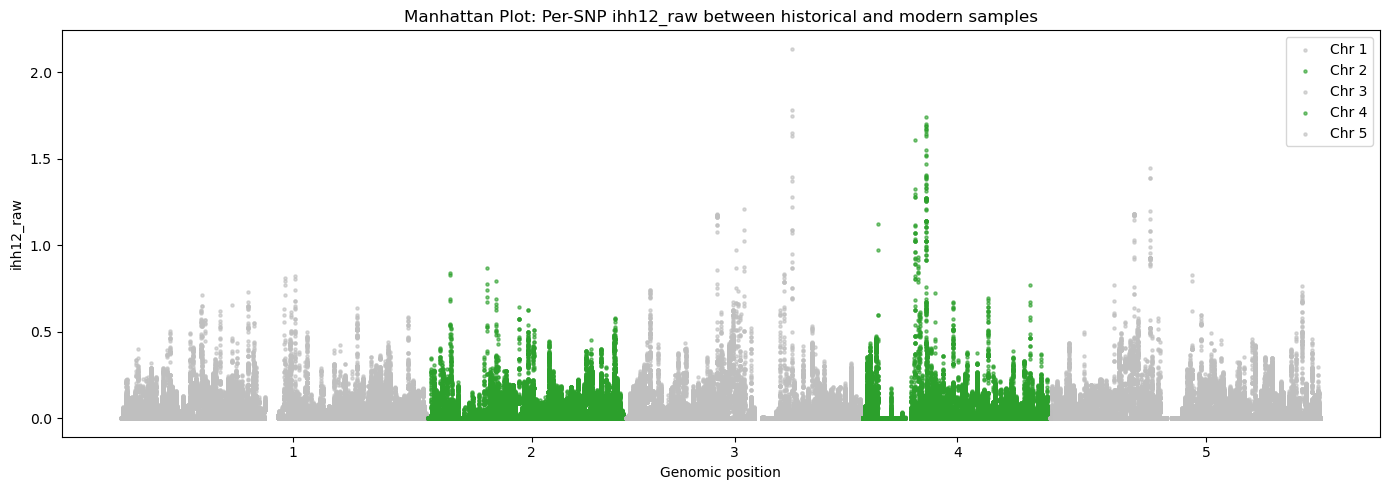

In [32]:
plt.figure(figsize=(14, 5))
colors = ['#bfbfbf', '#2ca02c']

for i, (chrom, group) in enumerate(df.groupby('chrom')):
    plt.scatter(group['pos_cum'], group['ihh12_norm'], s=5, alpha=0.6, color=colors[i % 2], label=f'Chr {group.chrom.iloc[0]}')
plt.legend().remove() 


# Chromosome ticks
xticks = df.groupby('chrom')['pos_cum'].median()
xtick_labels = df.groupby('chrom')['chrom'].first()

plt.xticks(ticks=xticks, labels=xtick_labels)
plt.xlabel('Genomic position')
plt.ylabel('ihh12_raw')
plt.title('Manhattan Plot: Per-SNP ihh12_raw between historical and modern samples')
plt.legend()
plt.tight_layout()

# Draw grey vertical lines and add gene ID labels
for _, row in gene_df.iterrows():
    chrom = str(row['chrom'])
    gene_start = row['start']
    gene_ends = row['end']
    gene_id = row['gene_id']

    filter_df = df[(df['chrom'] == chrom) & (df['pos']>=gene_start-10000) & (df['pos']<=gene_ends+10000)]
    gene_pos_cum = filter_df.sample(1)['pos_cum'].values[0]

    # Plot vertical line
    plt.axvline(gene_pos_cum, color='grey', linestyle='--', linewidth=0.6)

    # Add gene label
    plt.text(gene_pos_cum - 7e5, df['ihh12_norm'].max() * 0.7, gene_id,
             rotation=90, 
             fontsize=7, color='grey', ha='center')

plt.show()

In [112]:
df = df.sample(frac = .5)

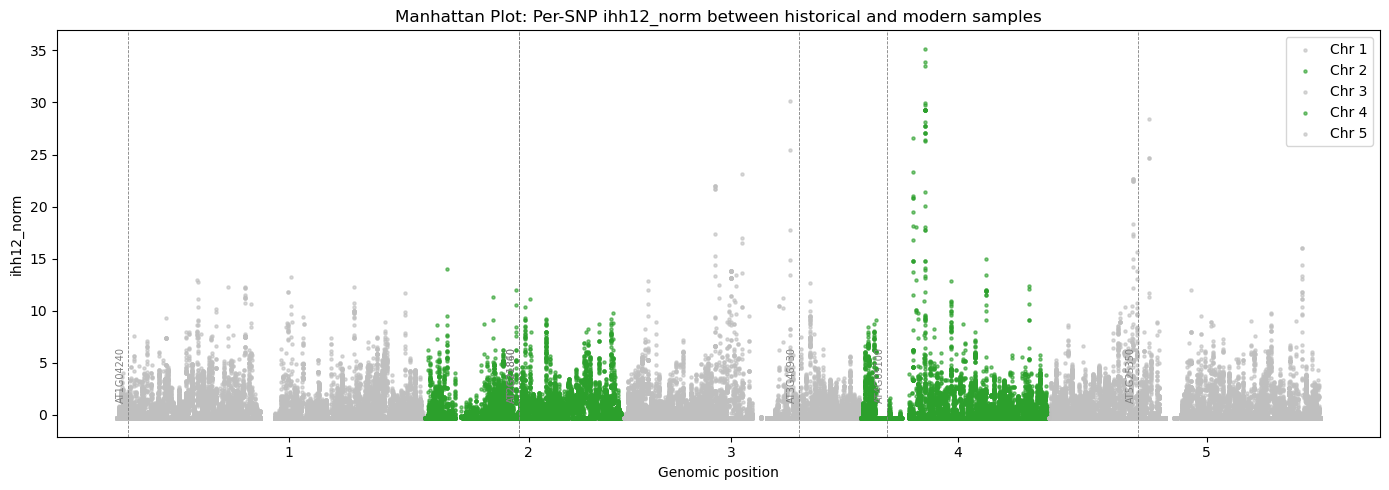

In [115]:
plt.figure(figsize=(14, 5))
colors = ['#bfbfbf', '#2ca02c']

for i, (chrom, group) in enumerate(df.groupby('chrom')):
    plt.scatter(group['pos_cum'], group['ihh12_norm'], s=5, alpha=0.6, color=colors[i % 2], label=f'Chr {group.chrom.iloc[0]}')
plt.legend().remove() 


# Chromosome ticks
xticks = df.groupby('chrom')['pos_cum'].median()
xtick_labels = df.groupby('chrom')['chrom'].first()

plt.xticks(ticks=xticks, labels=xtick_labels)
plt.xlabel('Genomic position')
plt.ylabel('ihh12_norm')
plt.title('Manhattan Plot: Per-SNP ihh12_norm between historical and modern samples')
plt.legend()
plt.tight_layout()

for _, row in gene_df.iterrows():
    chrom = row['chrom']
    gene_start = row['start']
    gene_ends = row['end']
    gene_id = row['gene_id']

    filter_df = df[(df['chrom'] == chrom) & (df['pos']>=gene_start-10000) & (df['pos']<=gene_ends+10000)]
    gene_pos_cum = filter_df.sample(1)['pos_cum'].values[0]

    # Plot vertical line
    plt.axvline(gene_pos_cum, color='grey', linestyle='--', linewidth=0.6)

    # Add gene label
    plt.text(gene_pos_cum - 7e5, df['ihh12_raw'].max() * 0.7, gene_id,
             rotation=90, 
             fontsize=7, color='grey', ha='center')

plt.show()

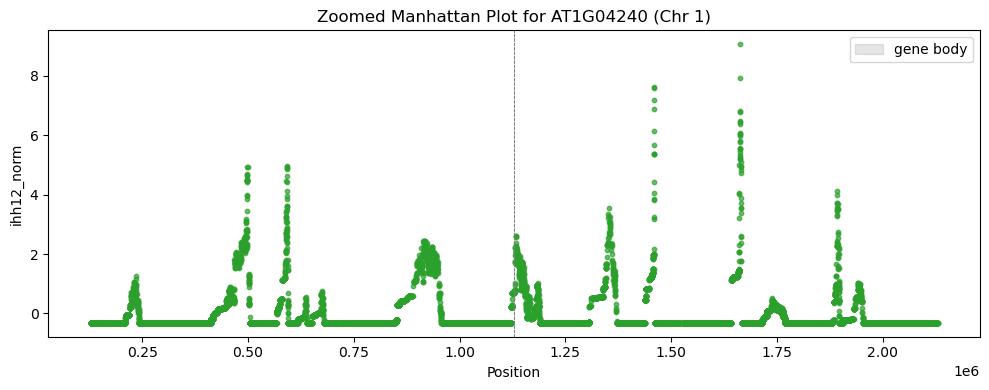

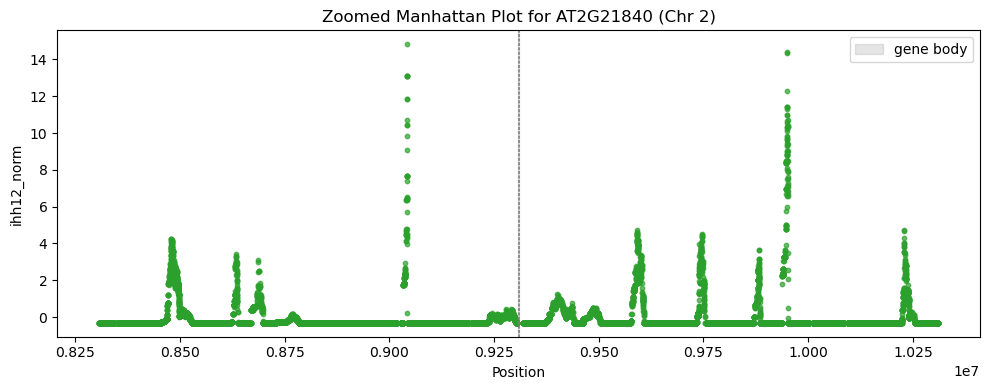

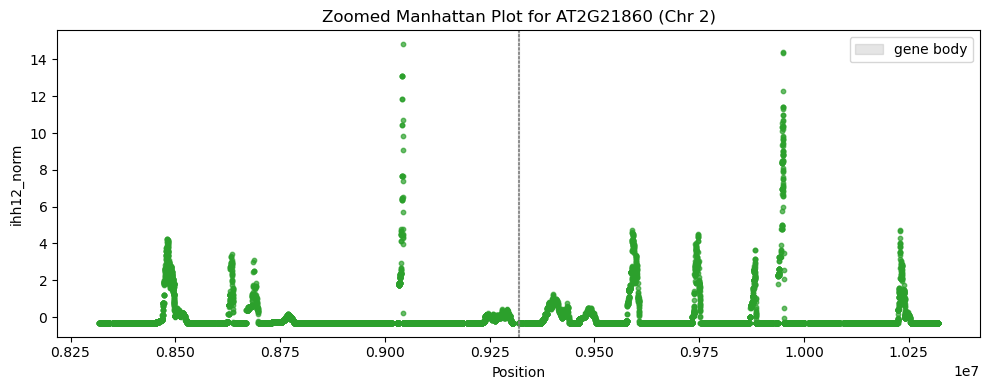

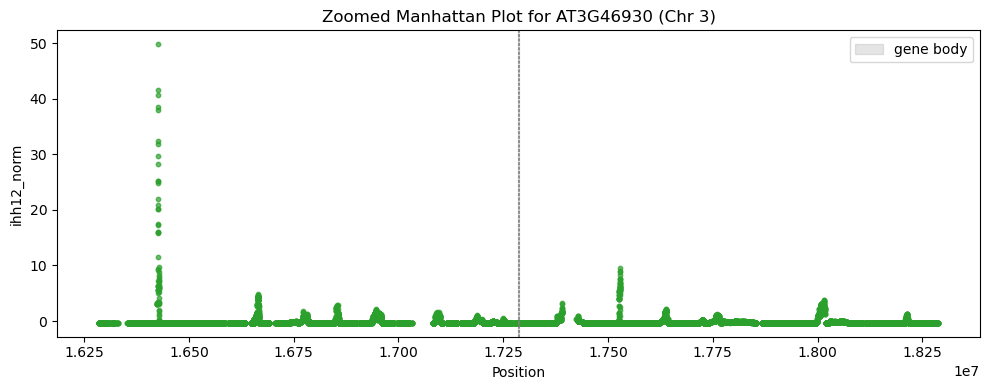

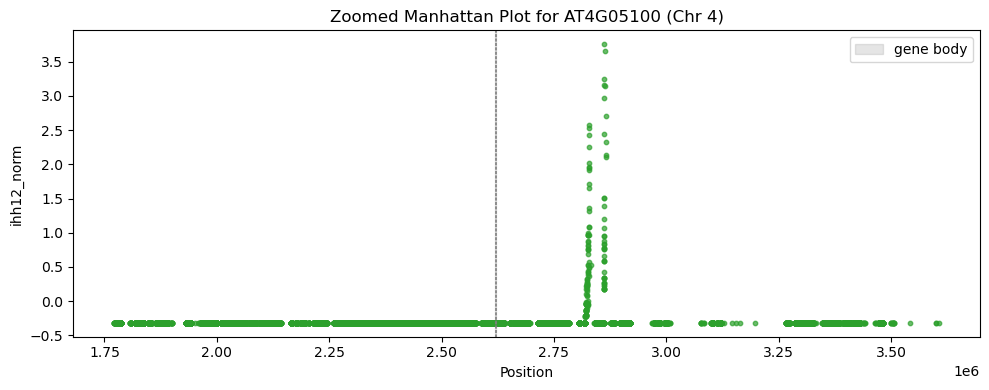

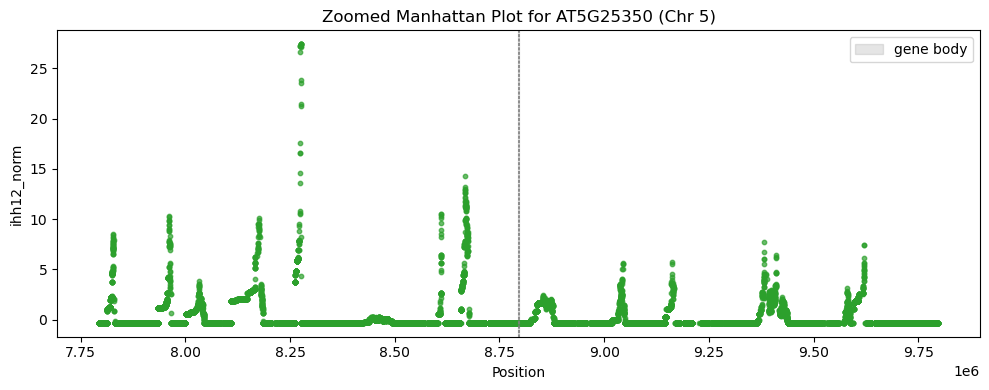

In [34]:
import matplotlib.pyplot as plt

for _, row in gene_df.iterrows():
    chrom = row['chrom']
    gene_start = row['start']
    gene_end = row['end']
    gene_id = row['gene_id']
    
    # Filter region: ±5kb around gene
    region_df = df[(df['chrom'] == chrom) & (df['pos'] >= gene_start - 1000000) & (df['pos'] <= gene_end + 1000000)]

    if region_df.empty:
        continue  # Skip if no data in region

    plt.figure(figsize=(10, 4))

    # Manhattan-style scatter
    plt.scatter(region_df['pos'], region_df['ihh12_norm'], s=10, alpha=0.7, color='#2ca02c')
    
    # Gene region highlight
    plt.axvspan(gene_start, gene_end, color='grey', alpha=0.2, label='gene body')
    plt.axvline(gene_start, color='grey', linestyle='--', linewidth=0.6)
    plt.axvline(gene_end, color='grey', linestyle='--', linewidth=0.6)

    # Plot labels
    plt.title(f'Zoomed Manhattan Plot for {gene_id} (Chr {chrom})')
    plt.xlabel('Position')
    plt.ylabel('ihh12_norm')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [ ]:
## noiw ihs

In [65]:
import glob

# Get all files in the current directory that contain 'ihh12' and end in '.out'
ihs_out_files = glob.glob("selscan_*ihs*.out")

# Preview list
print(ihs_out_files)

['selscan_chr5_ihs.ihs.out', 'selscan_chr1_ihs.ihs.out', 'selscan_chr3_ihs.ihs.out', 'selscan_chr2_ihs.ihs.out', 'selscan_chr4_ihs.ihs.out']


In [ ]:
### but first run the normalization 

# norm --ihs --files *.ihs.out --bins 100


In [71]:
# Get all files in the current directory that contain 'ihh12' and end in '.out'
ihs_out_files = glob.glob("*ihs.out.100bins.norm")

# Preview list
print(ihs_out_files)

['selscan_chr3_ihs.ihs.out.100bins.norm', 'selscan_chr2_ihs.ihs.out.100bins.norm', 'selscan_chr1_ihs.ihs.out.100bins.norm', 'selscan_chr4_ihs.ihs.out.100bins.norm', 'selscan_chr5_ihs.ihs.out.100bins.norm']


In [72]:
import pandas as pd

# Read and concatenate them
dfs = []
for f in ihs_out_files:
    df = pd.read_csv(f, delim_whitespace=True, header=None)
    
    # Optionally add a chromosome identifier if needed
    chrom_num = f.split('_chr')[1].split('_')[0]
    df['chrom'] = int(chrom_num)
    
    dfs.append(df)

# Combine into one DataFrame
ihs_df = pd.concat(dfs, ignore_index=True)


In [76]:
ihs_df

0         1         2             3             4          5  \
0       .    127998  0.423280  4.354560e-11  1.076520e-09  -3.207680   
1       .    132891  0.470899  1.863600e-09  7.105570e-09  -1.338370   
2       .    140215  0.417989  2.803730e-09  6.924140e-09  -0.904062   
3       .    143643  0.058201  4.909920e-02  2.120730e-10  19.260200   
4       .    147606  0.063492  4.335250e-02  2.148900e-10  19.122500   
...    ..       ...       ...           ...           ...        ...   
444435  .  26722729  0.068783  1.558460e-03  2.226100e-07   8.853790   
444436  .  26724023  0.063492  1.730660e-03  1.587160e-07   9.296900   
444437  .  26725650  0.063492  1.730660e-03  1.491690e-07   9.358930   
444438  .  26730223  0.089947  2.386910e-02  1.498020e-07  11.978800   
444439  .  26739981  0.132275  1.279270e-03  1.465470e-03  -0.135889   

               6  7  chrom  
0      -0.713363  0      3  
1      -0.295886  0      3  
2      -0.495697  0      3  
3       1.363640  0      3  
4       1.404950  0      3  
...          ... ..    ...  
444435 -0.121895  0      5  
444436 -0.056009  0      5  
444437 -0.046786  0      5  
444438  0.447094  0      5  
444439 -1.171560  0      5  

[444440 rows x 9 columns]

In [80]:
ihs_df.columns = ['id',
    "pos",             # 0
    "freq_derived",         # 1
    "iHH_ancestral",        # 2
    "iHH_derived",          # 3
    "unstandardized_iHS",   # 4
    "iHS",                  # 5
    "flag",                # 6          # 7
    "chrom"                 # 8
]

In [79]:
ihs_df.dtypes

id                     object
position                int64
freq_derived          float64
iHH_ancestral         float64
iHH_derived           float64
unstandardized_iHS    float64
iHS                   float64
flag                    int64
chrom                   int64
dtype: object

In [26]:
#index_to_drop = ihs_df[ihs_df['ihh12_norm'] == 'normxpehh'].index

In [27]:
#ihh12_df = ihh12_df.drop(index_to_drop).reset_index(drop=True)

In [28]:
#ihh12_df['ihh12_norm'] = ihh12_df['ihh12_norm'].astype(float)

In [83]:
# Sort by chromosome and position
ihs_df = ihs_df.sort_values(["chrom", "pos"])

# Compute cumulative basepair position for plotting
chrom_offsets = ihs_df.groupby("chrom")["pos"].max().cumsum().shift(fill_value=0)
ihs_df["pos_cum"] = ihs_df.apply(lambda  row: row["pos"] + chrom_offsets[row["chrom"]], axis=1)

In [3]:
gene_df = pd.read_csv('../genes_df.csv')

In [4]:
gene_df

gene_id  chrom     start       end  length
0  AT1G04240      1   1128149   1129689    1540
1  AT2G21840      2   9307024   9310358    3334
2  AT2G21860      2   9318122   9320024    1902
3  AT3G46930      3  17285565  17288077    2512
4  AT4G05100      4   2618372   2619947    1575
5  AT5G25350      5   8794252   8797349    3097

In [85]:
df = ihs_df.copy()

In [86]:
df.head()

id     pos  freq_derived  iHH_ancestral   iHH_derived  \
146367  .   75899      0.312169   4.374030e-08  4.660720e-08   
146368  .   78265      0.301587   4.773020e-08  4.620560e-08   
146369  .  100501      0.370370   5.737940e-08  5.614400e-08   
146370  .  105788      0.174603   7.003540e-08  5.058270e-08   
146371  .  107727      0.169312   5.853340e-08  4.867540e-08   

        unstandardized_iHS       iHS  flag  chrom  pos_cum  
146367           -0.063486 -0.642148     0      1    75899  
146368            0.032463 -0.652321     0      1    78265  
146369            0.021765 -0.406395     0      1   100501  
146370            0.325392 -0.987867     0      1   105788  
146371            0.184425 -1.014880     0      1   107727

In [65]:
#df = df.sample(frac = .7)

/tmp/ipykernel_2696783/3712119987.py:18: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/tbellagio/miniforge3/envs/pipeline_snakemake/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


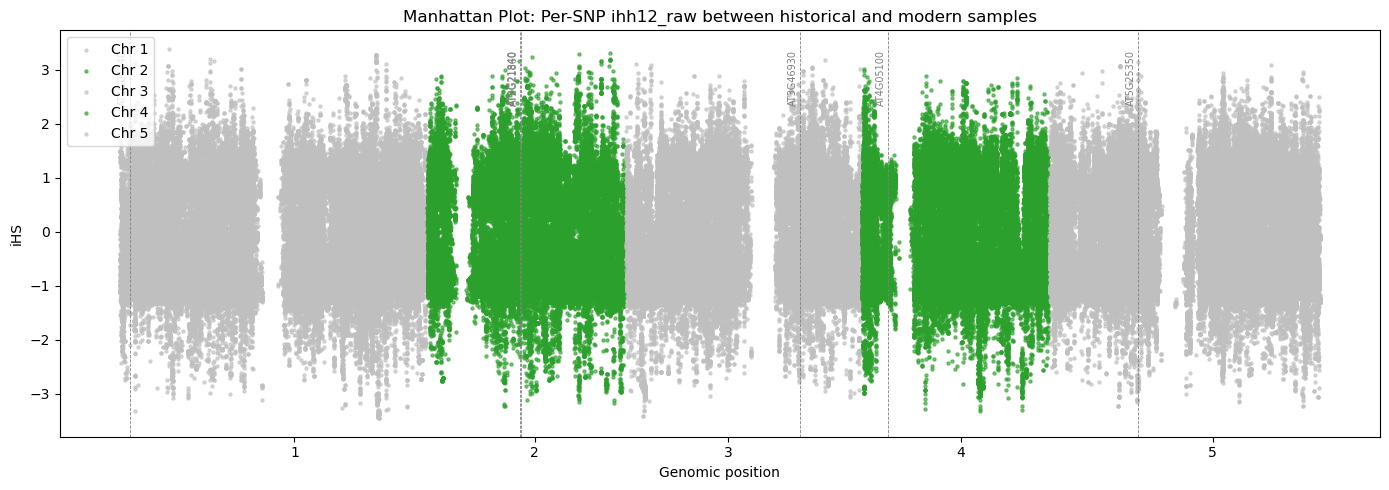

In [89]:
plt.figure(figsize=(14, 5))
colors = ['#bfbfbf', '#2ca02c']

for i, (chrom, group) in enumerate(df.groupby('chrom')):
    plt.scatter(group['pos_cum'], group['iHS'], s=5, alpha=0.6, color=colors[i % 2], label=f'Chr {group.chrom.iloc[0]}')
plt.legend().remove() 


# Chromosome ticks
xticks = df.groupby('chrom')['pos_cum'].median()
xtick_labels = df.groupby('chrom')['chrom'].first()

plt.xticks(ticks=xticks, labels=xtick_labels)
plt.xlabel('Genomic position')
plt.ylabel('iHS')
plt.title('Manhattan Plot: Per-SNP ihh12_raw between historical and modern samples')
plt.legend()
plt.tight_layout()

# Draw grey vertical lines and add gene ID labels
for _, row in gene_df.iterrows():
    chrom = row['chrom']
    gene_start = row['start']
    gene_ends = row['end']
    gene_id = row['gene_id']

    # Compute gene center
    gene_center = (gene_start + gene_ends) // 2

    # Subset df by chromosome
    subset = df[df['chrom'] == chrom]

    # Find the nearest position to the gene center
    nearest_idx = (subset['pos'] - gene_center).abs().idxmin()
    gene_pos_cum = subset.loc[nearest_idx, 'pos_cum']

    # Plot vertical line at gene
    plt.axvline(gene_pos_cum, color='grey', linestyle='--', linewidth=0.6)

    # Add gene label
    plt.text(gene_pos_cum - 7e5, df['iHS'].max() * 0.7, gene_id,
             rotation=90, fontsize=7, color='grey', ha='center')

plt.show()

In [112]:
#df = df.sample(frac = .5)

In [ ]:
plt.figure(figsize=(14, 5))
colors = ['#bfbfbf', '#2ca02c']

for i, (chrom, group) in enumerate(df.groupby('chrom')):
    plt.scatter(group['pos_cum'], group['iHS'], s=5, alpha=0.6, color=colors[i % 2], label=f'Chr {group.chrom.iloc[0]}')
plt.legend().remove() 


# Chromosome ticks
xticks = df.groupby('chrom')['pos_cum'].median()
xtick_labels = df.groupby('chrom')['chrom'].first()

plt.xticks(ticks=xticks, labels=xtick_labels)
plt.xlabel('Genomic position')
plt.ylabel('iHS')
plt.title('Manhattan Plot: Per-SNP iHS_norm between historical and modern samples')
plt.legend()
plt.tight_layout()

for _, row in gene_df.iterrows():
    chrom = row['chrom']
    gene_start = row['start']
    gene_ends = row['end']
    gene_id = row['gene_id']

    filter_df = df[(df['chrom'] == chrom) & (df['pos']>=gene_start-10000) & (df['pos']<=gene_ends+10000)]
    gene_pos_cum = filter_df.sample(1)['pos_cum'].values[0]

    # Plot vertical line
    plt.axvline(gene_pos_cum, color='grey', linestyle='--', linewidth=0.6)

    # Add gene label
    plt.text(gene_pos_cum - 7e5, df['iHS'].max() * 0.7, gene_id,
             rotation=90, 
             fontsize=7, color='grey', ha='center')

plt.show()

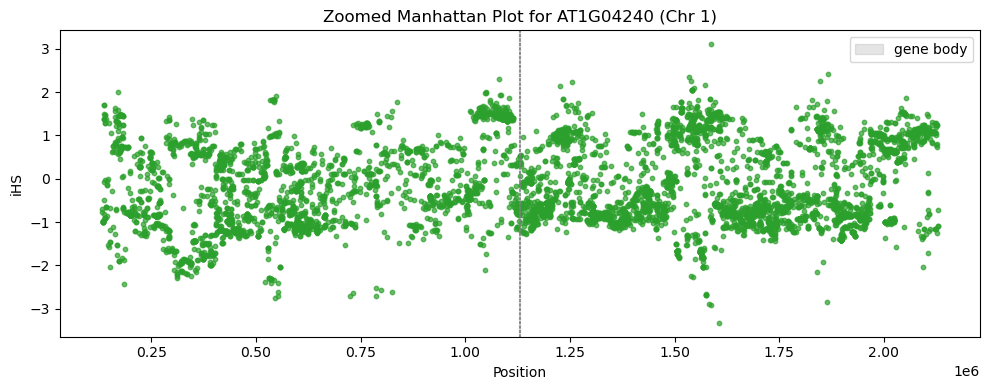

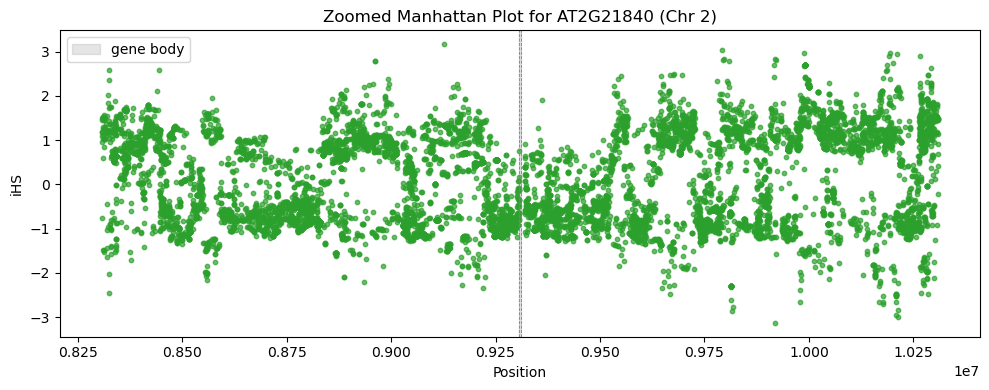

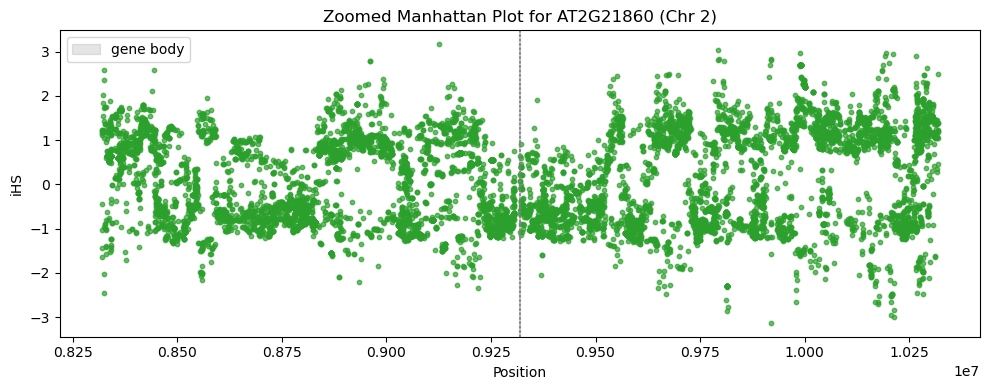

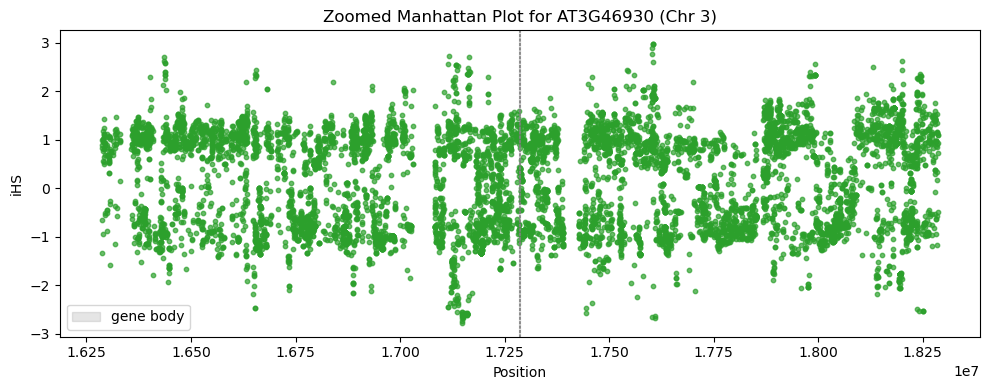

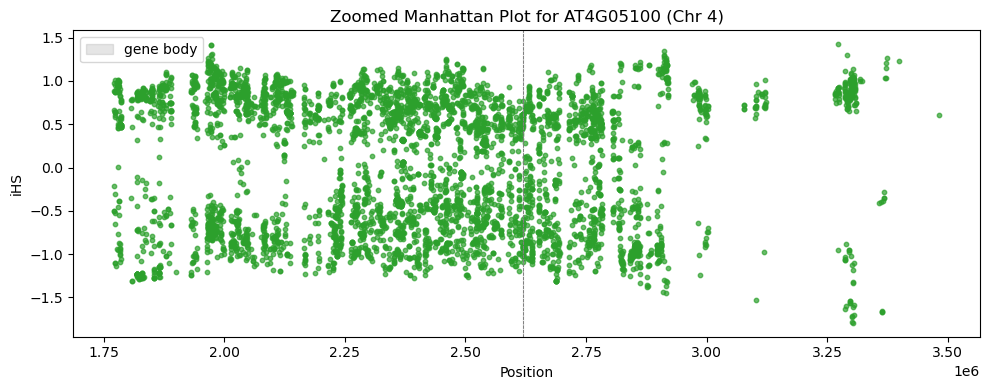

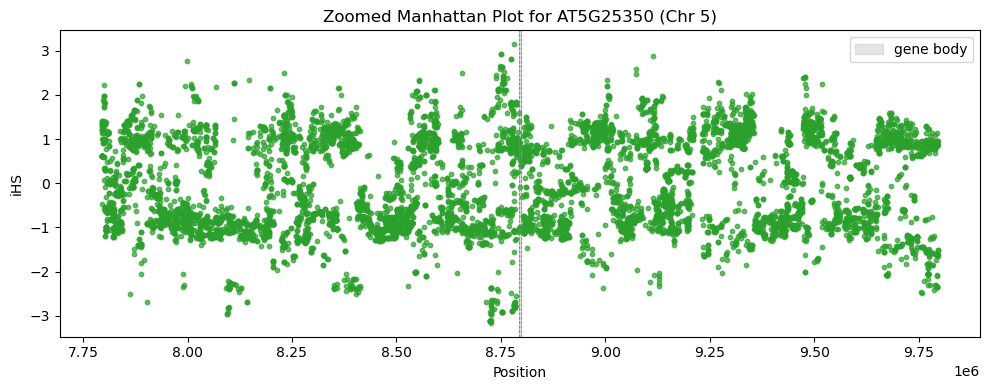

In [91]:
import matplotlib.pyplot as plt

for _, row in gene_df.iterrows():
    chrom = row['chrom']
    gene_start = row['start']
    gene_end = row['end']
    gene_id = row['gene_id']
    
    # Filter region: ±5kb around gene
    region_df = df[(df['chrom'] == chrom) & (df['pos'] >= gene_start - 1000000) & (df['pos'] <= gene_end + 1000000)]

    if region_df.empty:
        continue  # Skip if no data in region

    plt.figure(figsize=(10, 4))

    # Manhattan-style scatter
    plt.scatter(region_df['pos'], region_df['iHS'], s=10, alpha=0.7, color='#2ca02c')
    
    # Gene region highlight
    plt.axvspan(gene_start, gene_end, color='grey', alpha=0.2, label='gene body')
    plt.axvline(gene_start, color='grey', linestyle='--', linewidth=0.6)
    plt.axvline(gene_end, color='grey', linestyle='--', linewidth=0.6)

    # Plot labels
    plt.title(f'Zoomed Manhattan Plot for {gene_id} (Chr {chrom})')
    plt.xlabel('Position')
    plt.ylabel('iHS')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [36]:
import glob

# Get all files in the current directory that contain 'ihh12' and end in '.out'
pi_out_files = glob.glob("selscan_maf01*pi.100bp.out")

# Preview list
print(pi_out_files)

['selscan_maf01_chr5_pi.pi.100bp.out', 'selscan_maf01_chr4_pi.pi.100bp.out', 'selscan_maf01_chr2_pi.pi.100bp.out', 'selscan_maf01_chr3_pi.pi.100bp.out', 'selscan_maf01_chr1_pi.pi.100bp.out']


In [37]:
pi_out_files

['selscan_maf01_chr5_pi.pi.100bp.out',
 'selscan_maf01_chr4_pi.pi.100bp.out',
 'selscan_maf01_chr2_pi.pi.100bp.out',
 'selscan_maf01_chr3_pi.pi.100bp.out',
 'selscan_maf01_chr1_pi.pi.100bp.out']

In [38]:
import pandas as pd



# Read and concatenate them
dfs = []
for f in pi_out_files:
    df = pd.read_csv(f, delim_whitespace=True, header=None)
    
    # Optionally add a chromosome identifier if needed
    chrom_num = f.split('_chr')[1].split('_')[0]
    df['chrom'] = int(chrom_num)
    
    dfs.append(df)

# Combine into one DataFrame
pi_df = pd.concat(dfs, ignore_index=True)


In [39]:
pi_df.columns = ['window_start', 'window_end', 'pi', 'chrom']

In [40]:
pi_df.dtypes

window_start      int64
window_end        int64
pi              float64
chrom             int64
dtype: object

In [41]:
# First, sort by chromosome and window_start
pi_df = pi_df.sort_values(['chrom', 'window_start'])

# Get chromosome lengths
chrom_max = pi_df.groupby('chrom')['window_end'].max().sort_index()

# Compute chromosome offsets
chrom_offsets = chrom_max.cumsum() - chrom_max
offset_dict = chrom_offsets.to_dict()

# Apply offset
pi_df['pos_cum'] = pi_df.apply(lambda row: row['window_start'] + offset_dict[row['chrom']], axis=1)


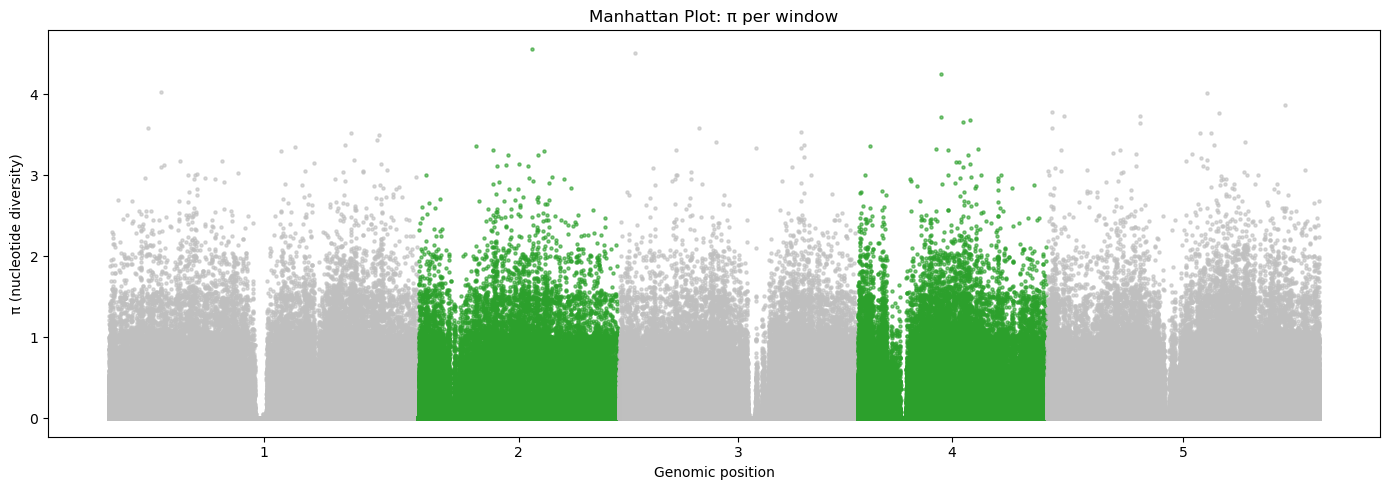

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))
colors = ['#bfbfbf', '#2ca02c']

for i, (chrom, group) in enumerate(pi_df.groupby('chrom')):
    plt.scatter(group['pos_cum'], group['pi'], s=5, alpha=0.6, color=colors[i % 2], label=f'Chr {chrom}')

# Chromosome tick labels
xticks = pi_df.groupby('chrom')['pos_cum'].median()
xtick_labels = pi_df.groupby('chrom')['chrom'].first()

plt.xticks(ticks=xticks, labels=xtick_labels)
plt.xlabel('Genomic position')
plt.ylabel('π (nucleotide diversity)')
plt.title('Manhattan Plot: π per window')
plt.legend().remove()
plt.tight_layout()
plt.show()


In [44]:
df

0         1         2  chrom
0              1       100  0.000000      1
1            101       200  0.000000      1
2            201       300  0.000000      1
3            301       400  0.594052      1
4            401       500  0.181326      1
...          ...       ...       ...    ...
304178  30417801  30417900  0.143264      1
304179  30417901  30418000  0.111939      1
304180  30418001  30418100  0.000000      1
304181  30418101  30418200  0.000000      1
304182  30418201  30418300  0.354680      1

[304183 rows x 4 columns]

In [212]:
gene_df

gene_id  chrom     start       end  length
0  AT1G04240      1   1128149   1129689    1540
1  AT2G21840      2   9307024   9310358    3334
2  AT2G21860      2   9318122   9320024    1902
3  AT3G46930      3  17285565  17288077    2512
4  AT4G05100      4   2618372   2619947    1575
5  AT5G25350      5   8794252   8797349    3097

In [58]:
from scipy.stats import zscore
pi_df['pi_z'] = zscore(pi_df['pi'])

In [92]:
pi_df

window_start  window_end        pi  chrom      pos_cum      pi_z
885325             1         100  0.000000      1          1.0 -0.510376
885326           101         200  0.000000      1        101.0 -0.510376
885327           201         300  0.000000      1        201.0 -0.510376
885328           301         400  0.594052      1        301.0  1.725342
885329           401         500  0.181326      1        401.0  0.172046
...              ...         ...       ...    ...          ...       ...
267903      26790301    26790400  0.072643      5  118950301.0 -0.236985
267904      26790401    26790500  0.932340      5  118950401.0  2.998491
267905      26790501    26790600  0.000000      5  118950501.0 -0.510376
267906      26790601    26790700  0.000000      5  118950601.0 -0.510376
267907      26790701    26790800  0.158534      5  118950701.0  0.086268

[1189508 rows x 6 columns]

/tmp/ipykernel_2696783/671513031.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df['pos'] = (region_df['window_start'] + region_df['window_end']) // 2
/tmp/ipykernel_2696783/671513031.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df['distance'] = region_df['pos'] - gene_center
/tmp/ipykernel_2696783/671513031.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

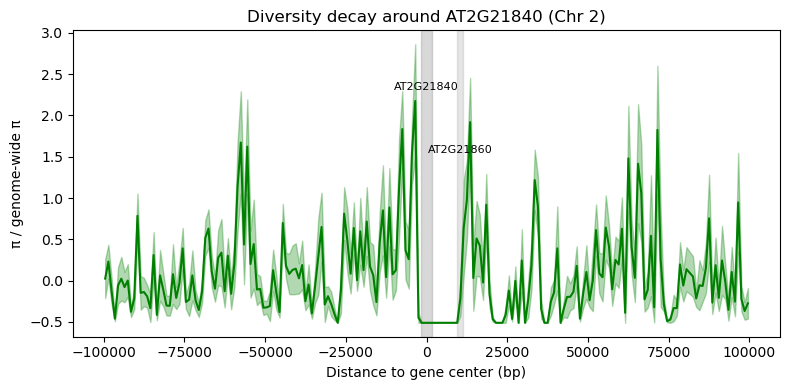

In [59]:
chrom = 2
gene_start = 9307024
gene_end = 9310358


# Filter region: ±5kb around gene
region_df = pi_df[(pi_df['chrom'] == chrom) & (pi_df['window_start'] >= gene_start - 1000000) & (pi_df['window_start'] <= gene_end + 1000000)]


region_df['pos'] = (region_df['window_start'] + region_df['window_end']) // 2



gene_center = (gene_start + gene_end) // 2

# Add distance from gene center
region_df['distance'] = region_df['pos'] - gene_center

# Bin data for SEM calculation
region_df['bin'] = pd.cut(region_df['distance'], bins=np.arange(-100000, 100001, 1000))
binned = region_df.groupby('bin')['pi_z'].agg(['mean', 'sem']).reset_index()
binned['center'] = binned['bin'].apply(lambda x: x.mid)


# Plot
plt.figure(figsize=(8, 4))
plt.plot(binned['center'], binned['mean'], color='green', label='Mean π (normalized)')
plt.fill_between(binned['center'], binned['mean'] - binned['sem'], binned['mean'] + binned['sem'],
                 alpha=0.3, color='green', label='±1 SEM')

# Gene positions
gene1_start, gene1_end = 9307024, 9310358
gene2_start, gene2_end = 9318122, 9320024
gene1_center = (gene1_start + gene1_end) // 2

# Add gene spans using same reference point
plt.axvspan(gene1_start - gene1_center, gene1_end - gene1_center, color='grey', alpha=0.3)
plt.axvspan(gene2_start - gene1_center, gene2_end - gene1_center, color='darkgrey', alpha=0.3)

# Add labels on top of the shaded boxes
plt.text((gene1_start + gene1_end) / 2 - gene1_center, max(binned['mean']) * 1.05, 'AT2G21840',
         ha='center', va='bottom', fontsize=8, color='black')
plt.text((gene2_start + gene2_end) / 2 - gene1_center, max(binned['mean']) * 0.7, 'AT2G21860',
         ha='center', va='bottom', fontsize=8, color='black')

# Final plot settings
plt.xlabel('Distance to gene center (bp)')
plt.ylabel('π / genome-wide π')
plt.title('Diversity decay around AT2G21840 (Chr 2)')
plt.tight_layout()
plt.show()


In [67]:
pi_df.to_csv('pi_all_maf01.csv',index=None)

/tmp/ipykernel_2696783/3729217002.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df['pos'] = (region_df['window_start'] + region_df['window_end']) // 2
/tmp/ipykernel_2696783/3729217002.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  region_df['distance'] = region_df['pos'] - gene_center
/tmp/ipykernel_2696783/3729217002.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

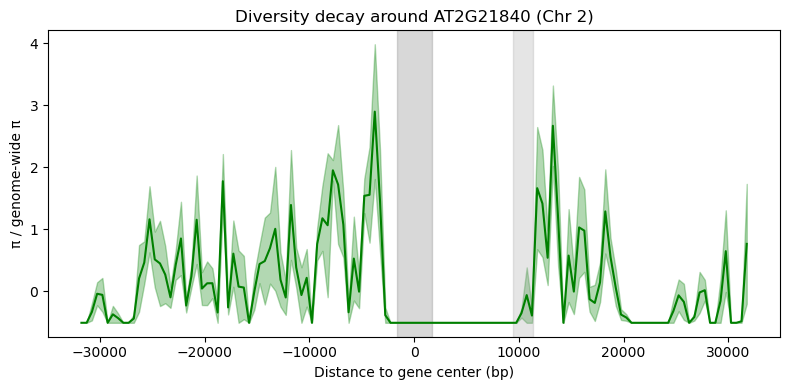

In [61]:
chrom = 2
gene_start = 9307024
gene_end = 9310358


# Filter region: ±5kb around gene
region_df = pi_df[(pi_df['chrom'] == chrom) & (pi_df['window_start'] >= gene_start - 30000) & (pi_df['window_start'] <= gene_end + 30000)]


region_df['pos'] = (region_df['window_start'] + region_df['window_end']) // 2



gene_center = (gene_start + gene_end) // 2

# Add distance from gene center
region_df['distance'] = region_df['pos'] - gene_center

# Bin data for SEM calculation
region_df['bin'] = pd.cut(region_df['distance'], bins=np.arange(-100000, 100001, 500))
binned = region_df.groupby('bin')['pi_z'].agg(['mean', 'sem']).reset_index()
binned['center'] = binned['bin'].apply(lambda x: x.mid)


# Plot
plt.figure(figsize=(8, 4))
plt.plot(binned['center'], binned['mean'], color='green', label='Mean π (normalized)')
plt.fill_between(binned['center'], binned['mean'] - binned['sem'], binned['mean'] + binned['sem'],
                 alpha=0.3, color='green', label='±1 SEM')

# Gene positions
gene1_start, gene1_end = 9307024, 9310358
gene2_start, gene2_end = 9318122, 9320024
gene1_center = (gene1_start + gene1_end) // 2

# Add gene spans using same reference point
plt.axvspan(gene1_start - gene1_center, gene1_end - gene1_center, color='grey', alpha=0.3)
plt.axvspan(gene2_start - gene1_center, gene2_end - gene1_center, color='darkgrey', alpha=0.3)

# Add labels on top of the shaded boxes
plt.text((gene1_start + gene1_end) / 2 - gene1_center, max(binned['mean']) * 1.05, 'AT2G21840',
         ha='center', va='bottom', fontsize=8, color='black')
plt.text((gene2_start + gene2_end) / 2 - gene1_center, max(binned['mean']) * 0.7, 'AT2G21860',
         ha='center', va='bottom', fontsize=8, color='black')

# Final plot settings
plt.xlabel('Distance to gene center (bp)')
plt.ylabel('π / genome-wide π')
plt.title('Diversity decay around AT2G21840 (Chr 2)')
plt.tight_layout()
plt.show()


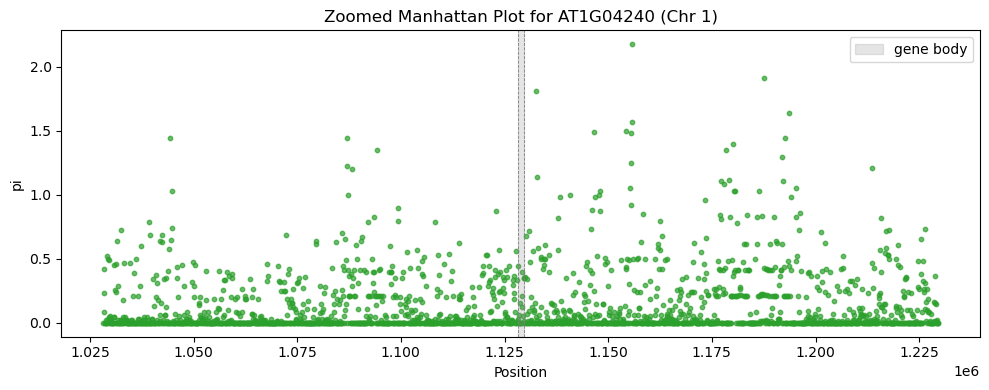

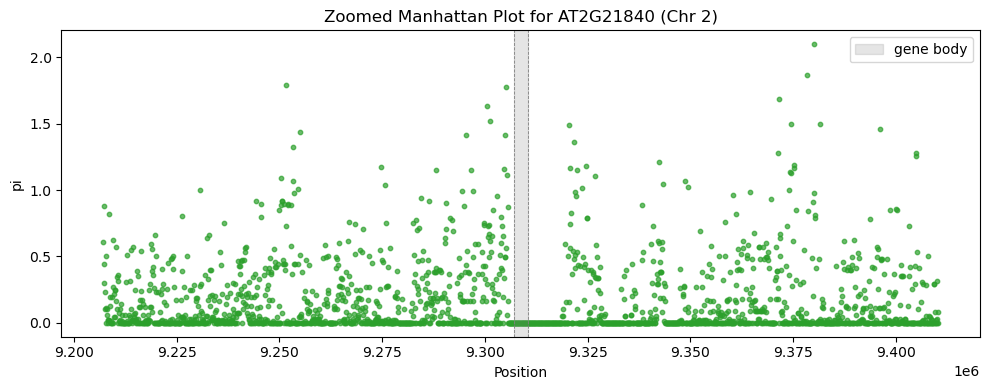

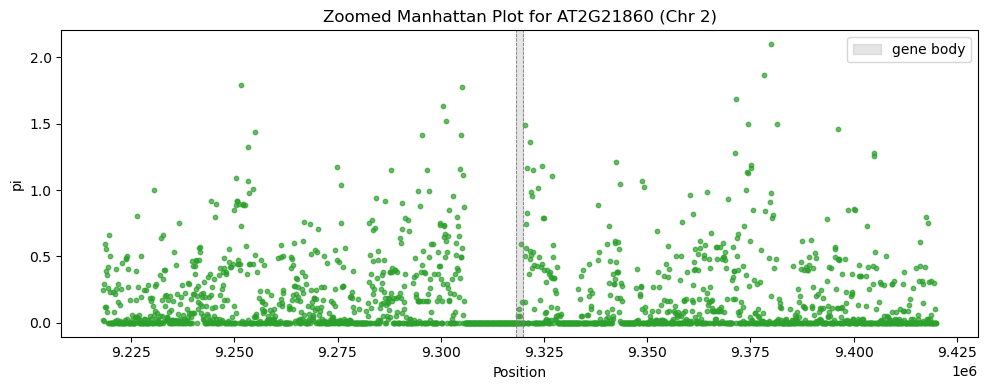

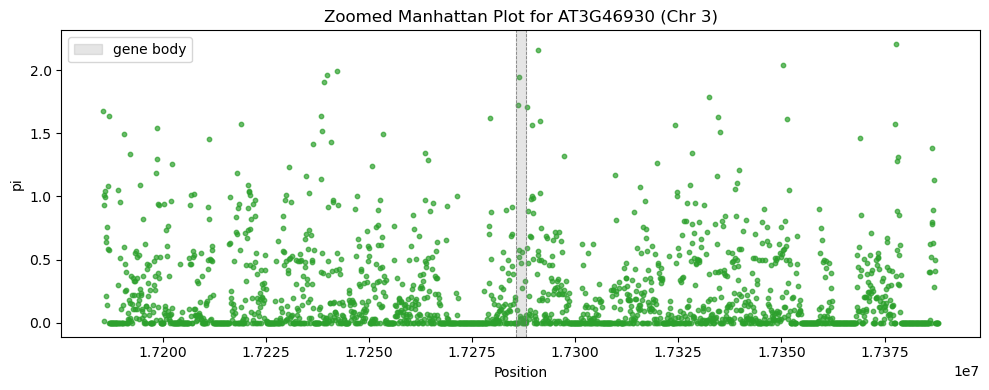

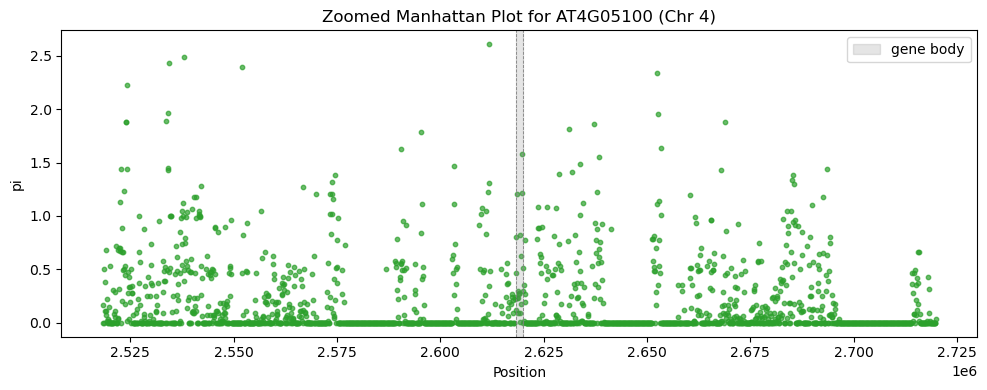

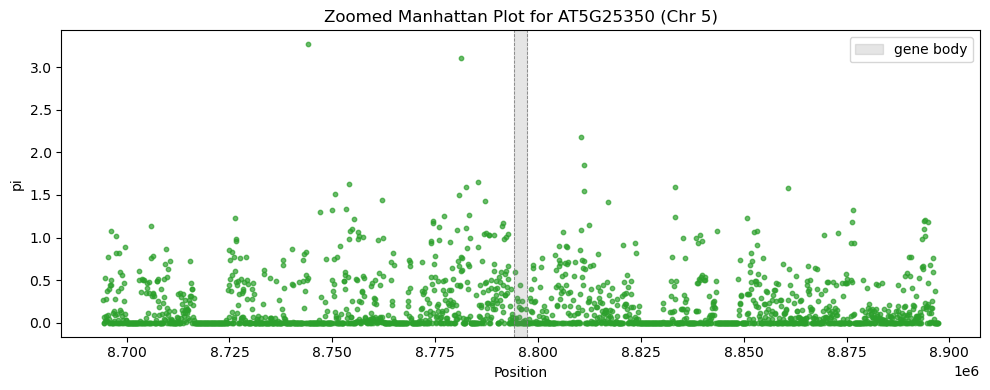

In [55]:
import matplotlib.pyplot as plt

for _, row in gene_df.iterrows():
    chrom = row['chrom']
    gene_start = row['start']
    gene_end = row['end']
    gene_id = row['gene_id']
    
    # Filter region: ±5kb around gene
    region_df = df[(df['chrom'] == chrom) & (df['window_start'] >= gene_start - 100000) & (df['window_start'] <= gene_end + 100000)]

    if region_df.empty:
        continue  # Skip if no data in region

    plt.figure(figsize=(10, 4))

    # Manhattan-style scatter
    plt.scatter(region_df['window_start'], region_df['pi'], s=10, alpha=0.7, color='#2ca02c')
    
    # Gene region highlight
    plt.axvspan(gene_start, gene_end, color='grey', alpha=0.2, label='gene body')
    plt.axvline(gene_start, color='grey', linestyle='--', linewidth=0.6)
    plt.axvline(gene_end, color='grey', linestyle='--', linewidth=0.6)

    # Plot labels
    plt.title(f'Zoomed Manhattan Plot for {gene_id} (Chr {chrom})')
    plt.xlabel('Position')
    plt.ylabel('pi')
    plt.legend()
    plt.tight_layout()
    plt.show()


In [47]:
df = pi_df.copy()

In [48]:
df.dtypes

window_start      int64
window_end        int64
pi              float64
chrom             int64
pos_cum         float64
dtype: object

In [49]:
pi_df

window_start  window_end        pi  chrom      pos_cum
885325             1         100  0.000000      1          1.0
885326           101         200  0.000000      1        101.0
885327           201         300  0.000000      1        201.0
885328           301         400  0.594052      1        301.0
885329           401         500  0.181326      1        401.0
...              ...         ...       ...    ...          ...
267903      26790301    26790400  0.072643      5  118950301.0
267904      26790401    26790500  0.932340      5  118950401.0
267905      26790501    26790600  0.000000      5  118950501.0
267906      26790601    26790700  0.000000      5  118950601.0
267907      26790701    26790800  0.158534      5  118950701.0

[1189508 rows x 5 columns]

In [148]:
chrom

2

In [50]:
gene_center = (gene_start + gene_ends) // 2

# Subset just the chromosome
subset = df[df['chrom'] == chrom]

# Get the index of the nearest position
nearest_idx = (subset['pos_cum'] - gene_center).abs().idxmin()

# Retrieve the corresponding pos_cum
gene_pos_cum = subset.loc[nearest_idx, 'pos_cum']


In [51]:
gene_pos_cum

1128901.0

In [52]:
gene_df.dtypes


gene_id    object
chrom       int64
start       int64
end         int64
length      int64
dtype: object

In [53]:
df.dtypes

window_start      int64
window_end        int64
pi              float64
chrom             int64
pos_cum         float64
dtype: object

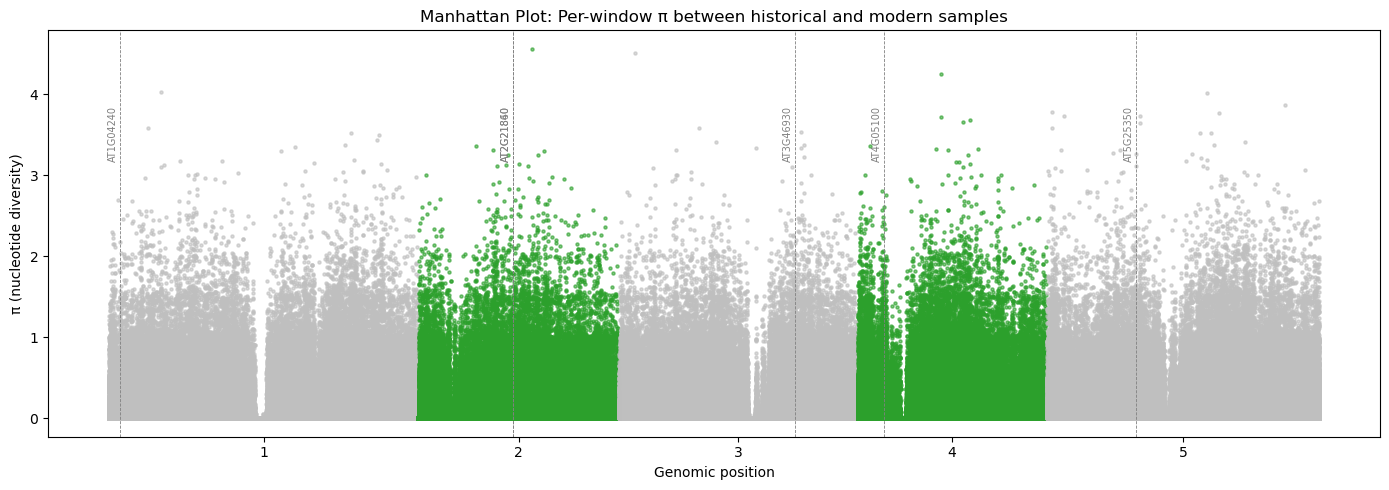

In [54]:
plt.figure(figsize=(14, 5))
colors = ['#bfbfbf', '#2ca02c']

# Scatter plot of pi by chromosome
for i, (chrom, group) in enumerate(df.groupby('chrom')):
    plt.scatter(group['pos_cum'], group['pi'], s=5, alpha=0.6, color=colors[i % 2], label=f'Chr {chrom}')
plt.legend().remove()

# Chromosome ticks
xticks = df.groupby('chrom')['pos_cum'].median()
xtick_labels = df.groupby('chrom')['chrom'].first()
plt.xticks(ticks=xticks, labels=xtick_labels)

plt.xlabel('Genomic position')
plt.ylabel('π (nucleotide diversity)')
plt.title('Manhattan Plot: Per-window π between historical and modern samples')
plt.tight_layout()

# Annotate gene locations
for _, row in gene_df.iterrows():
    chrom = row['chrom']
    gene_start = row['start']
    gene_ends = row['end']
    gene_id = row['gene_id']

    # Compute gene center
    gene_center = (gene_start + gene_ends) // 2

    # Subset df by chromosome
    subset = df[df['chrom'] == chrom]

    # Find the nearest position to the gene center
    nearest_idx = (subset['window_start'] - gene_center).abs().idxmin()
    gene_pos_cum = subset.loc[nearest_idx, 'pos_cum']

    # Plot vertical line at gene
    plt.axvline(gene_pos_cum, color='grey', linestyle='--', linewidth=0.6)

    # Add gene label
    plt.text(gene_pos_cum - 7e5, df['pi'].max() * 0.7, gene_id,
             rotation=90, fontsize=7, color='grey', ha='center')

plt.show()


In [163]:
pi_df

window_start  window_end        pi  chrom      pos_cum
885325             1         100  0.000000      1          1.0
885326           101         200  0.000000      1        101.0
885327           201         300  0.000000      1        201.0
885328           301         400  0.594052      1        301.0
885329           401         500  0.181326      1        401.0
...              ...         ...       ...    ...          ...
453748      26790301    26790400  0.072643      5  118950301.0
453749      26790401    26790500  0.932340      5  118950401.0
453750      26790501    26790600  0.000000      5  118950501.0
453751      26790601    26790700  0.000000      5  118950601.0
453752      26790701    26790800  0.158534      5  118950701.0

[1189508 rows x 5 columns]

In [164]:
from scipy.stats import zscore
pi_df['pi_z'] = zscore(pi_df['pi'])

In [167]:
df = pi_df.copy()

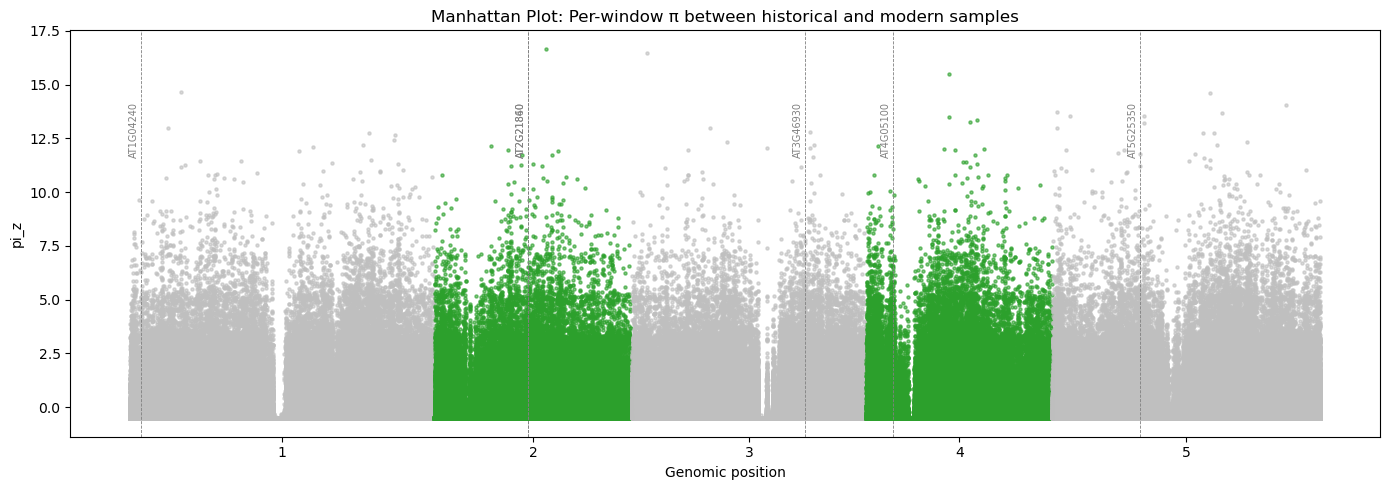

In [170]:
plt.figure(figsize=(14, 5))
colors = ['#bfbfbf', '#2ca02c']

# Scatter plot of pi_z by chromosome
for i, (chrom, group) in enumerate(df.groupby('chrom')):
    plt.scatter(group['pos_cum'], group['pi_z'], s=5, alpha=0.6, color=colors[i % 2], label=f'Chr {chrom}')
plt.legend().remove()

# Chromosome ticks
xticks = df.groupby('chrom')['pos_cum'].median()
xtick_labels = df.groupby('chrom')['chrom'].first()
plt.xticks(ticks=xticks, labels=xtick_labels)

plt.xlabel('Genomic position')
plt.ylabel('pi_z')
plt.title('Manhattan Plot: Per-window π between historical and modern samples')
plt.tight_layout()

# Annotate gene locations
for _, row in gene_df.iterrows():
    chrom = row['chrom']
    gene_start = row['start']
    gene_ends = row['end']
    gene_id = row['gene_id']

    # Compute gene center
    gene_center = (gene_start + gene_ends) // 2

    # Subset df by chromosome
    subset = df[df['chrom'] == chrom]

    # Find the nearest position to the gene center
    nearest_idx = (subset['window_start'] - gene_center).abs().idxmin()
    gene_pos_cum = subset.loc[nearest_idx, 'pos_cum']

    # Plot vertical line at gene
    plt.axvline(gene_pos_cum, color='grey', linestyle='--', linewidth=0.6)

    # Add gene label
    plt.text(gene_pos_cum - 7e5, df['pi_z'].max() * 0.7, gene_id,
             rotation=90, fontsize=7, color='grey', ha='center')

plt.show()


In [169]:
pi_df

window_start  window_end        pi  chrom      pos_cum      pi_z
885325             1         100  0.000000      1          1.0 -0.510376
885326           101         200  0.000000      1        101.0 -0.510376
885327           201         300  0.000000      1        201.0 -0.510376
885328           301         400  0.594052      1        301.0  1.725342
885329           401         500  0.181326      1        401.0  0.172046
...              ...         ...       ...    ...          ...       ...
453748      26790301    26790400  0.072643      5  118950301.0 -0.236985
453749      26790401    26790500  0.932340      5  118950401.0  2.998491
453750      26790501    26790600  0.000000      5  118950501.0 -0.510376
453751      26790601    26790700  0.000000      5  118950601.0 -0.510376
453752      26790701    26790800  0.158534      5  118950701.0  0.086268

[1189508 rows x 6 columns]

In [156]:
nearest_idx

185845

In [160]:
subset.loc[nearest_idx]['pos_cum']

window_start           1.0
window_end           100.0
pi                     0.0
chrom                  5.0
pos_cum         92160001.0
Name: 185845, dtype: float64

In [157]:
subset.loc[nearest_idx, 'pos_cum']

92160001.0

In [159]:
df[df['pos_cum'] == 92160001.0]

window_start  window_end   pi  chrom     pos_cum
185845             1         100  0.0      5  92160001.0

In [161]:
subset['pos_cum'] - gene_center).abs().idxmin()

SyntaxError: unmatched ')' (1492994867.py, line 1)